# Data preprocessing, Model Selection and hyperparameter tuning

## Importing essential packages

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import optuna
from sklearn import linear_model
from sklearn import ensemble
from sklearn import model_selection
from optuna.visualization.matplotlib import plot_param_importances
from sklearn.model_selection import train_test_split
import sklearn.svm
from sklearn.metrics import confusion_matrix,classification_report,accuracy_score,roc_auc_score
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import GaussianNB
import xgboost as xgb
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from pandas_profiling import ProfileReport
from sklearn.model_selection import train_test_split
from sklearn.feature_selection import VarianceThreshold
from imblearn.over_sampling import SMOTE
import warnings
import joblib
%matplotlib inline

## From EDA we made certain conclusions and we need to handle those before training any Model

## Loading and merging datasources

In [2]:
df1=pd.read_csv('data/applicant.csv')
df2=pd.read_csv('data/loan.csv')
df=pd.merge(df1,df2,on='applicant_id',how='left')

## Feature Engineering(To handle missing values,categorical to numerical feature conversion,Handling outliers in numerical features)

## Handling missing values

## Finding if missing values are from categorical or numerical features (Total 9 features have missing values)

In [3]:
features_with_missing_values=[feature for feature in df.columns if df[feature].isnull().sum()>0]
categorical_feature=[feature for feature in df.columns if df[feature].dtype=='O']
numerical_feature=[feature for feature in df.columns if df[feature].dtype!='O']

In [4]:
[item for item in categorical_feature if item in features_with_missing_values]

['Has_been_employed_for_at_least',
 'Has_been_employed_for_at_most',
 'Telephone',
 'Savings_account_balance',
 'Balance_in_existing_bank_account_(lower_limit_of_bucket)',
 'Balance_in_existing_bank_account_(upper_limit_of_bucket)',
 'Purpose',
 'Property',
 'Other_EMI_plans']

## All the missing values are from categorical features so it needs to be handled

In [5]:
#function to handle missing values after passing certain dataframe and feature name
def impute_nan(df,variable):
    """
                                Method Name: impute_nan
                                Description: handles missing values after we provide a dataframe and feature column
                                Outcome: we get a feature values without any missing values
                            

                                Written By: Saurabh Naik
                                Version: 1.0
                                Revisions: None
        """
    df["new_"+variable]=np.where(df[variable].isnull(),"Missing",df[variable])

## Handling missing values of categorical features 

In [6]:
for feature in features_with_missing_values:
    impute_nan(df,feature)
df.head()

,applicant_id,Primary_applicant_age_in_years,Gender,Marital_status,Number_of_dependents,Housing,Years_at_current_residence,Employment_status,Has_been_employed_for_at_least,Has_been_employed_for_at_most,...,high_risk_applicant,new_Has_been_employed_for_at_least,new_Has_been_employed_for_at_most,new_Telephone,new_Savings_account_balance,new_Balance_in_existing_bank_account_(lower_limit_of_bucket),new_Balance_in_existing_bank_account_(upper_limit_of_bucket),new_Purpose,new_Property,new_Other_EMI_plans
0,1469590,67,male,single,1,own,4,skilled employee / official,7 years,NaN,...,0,7 years,Missing,Registered under the applicant's name,Missing,Missing,0,electronic equipment,real estate,Missing
1,1203873,22,female,divorced/separated/married,1,own,2,skilled employee / official,1 year,4 years,...,1,1 year,4 years,Missing,Low,0,2 lac,electronic equipment,real estate,Missing
2,1432761,49,male,single,2,own,3,unskilled - resident,4 years,7 years,...,0,4 years,7 years,Missing,Low,Missing,Missing,education,real estate,Missing
3,1207582,45,male,single,2,for free,4,skilled employee / official,4 years,7 years,...,0,4 years,7 years,Missing,Low,Missing,0,FF&E,building society savings agreement/life insurance,Missing
4,1674436,53,male,single,2,for free,4,skilled employee / official,1 year,4 years,...,1,1 year,4 years,Missing,Low,Missing,0,new vehicle,Missing,Missing


In [7]:
df.drop(features_with_missing_values,axis=1,inplace=True)

## Missing values were handled after replacing them with new category "Missing" and checking the count of missing values

In [8]:
len([feature for feature in df.columns if df[feature].isnull().sum()>0])

0

## Converting categorical features into numerical features

In [9]:
#getting all categorical features
categorical_feature=[feature for feature in df.columns if df[feature].dtype=='O']
categorical_feature

['Gender',
 'Marital_status',
 'Housing',
 'Employment_status',
 'loan_application_id',
 'Loan_history',
 'new_Has_been_employed_for_at_least',
 'new_Has_been_employed_for_at_most',
 'new_Telephone',
 'new_Savings_account_balance',
 'new_Balance_in_existing_bank_account_(lower_limit_of_bucket)',
 'new_Balance_in_existing_bank_account_(upper_limit_of_bucket)',
 'new_Purpose',
 'new_Property',
 'new_Other_EMI_plans']

In [10]:
#Splitting categories into ordinal and nominal features
ordinal_feature=['Employment_status','Loan_history','new_Has_been_employed_for_at_least','new_Savings_account_balance','new_Purpose','new_Property','new_Balance_in_existing_bank_account_(lower_limit_of_bucket)','new_Other_EMI_plans']
nominal_feature = [x for x in categorical_feature if x not in ordinal_feature]

## Target guided encoding for ordinal features in train dataset

In [11]:
for feature in ordinal_feature:
    ordinal_labels=df.groupby([feature])['high_risk_applicant'].mean().sort_values().index
    ordinal_dict={k:i for i,k in enumerate(ordinal_labels,0)}
    df[feature+'_ordinal_labels']=df[feature].map(ordinal_dict)
df.drop(ordinal_feature,axis=1,inplace=True)

In [12]:
df.head()

,applicant_id,Primary_applicant_age_in_years,Gender,Marital_status,Number_of_dependents,Housing,Years_at_current_residence,Foreign_worker,loan_application_id,Months_loan_taken_for,...,new_Telephone,new_Balance_in_existing_bank_account_(upper_limit_of_bucket),Employment_status_ordinal_labels,Loan_history_ordinal_labels,new_Has_been_employed_for_at_least_ordinal_labels,new_Savings_account_balance_ordinal_labels,new_Purpose_ordinal_labels,new_Property_ordinal_labels,new_Balance_in_existing_bank_account_(lower_limit_of_bucket)_ordinal_labels,new_Other_EMI_plans_ordinal_labels
0,1469590,67,male,single,1,own,4,1,d68d975e-edad-11ea-8761-1d6f9c1ff461,6,...,Registered under the applicant's name,0,1,0,1,2,2,0,1,0
1,1203873,22,female,divorced/separated/married,1,own,2,1,d68d989e-edad-11ea-b1d5-2bcf65006448,48,...,Missing,2 lac,1,2,2,4,2,0,2,0
2,1432761,49,male,single,2,own,3,1,d68d995c-edad-11ea-814a-1b6716782575,12,...,Missing,Missing,0,0,0,4,9,0,1,0
3,1207582,45,male,single,2,for free,4,1,d68d99fc-edad-11ea-8841-17e8848060ae,42,...,Missing,0,1,2,0,4,3,1,1,0
4,1674436,53,male,single,2,for free,4,1,d68d9a92-edad-11ea-9f3d-1f8682db006a,24,...,Missing,0,1,1,2,4,7,3,1,0


## Mean encoding for nominal features

In [13]:
for feature in nominal_feature:
    nominal_labels=df.groupby([feature])['high_risk_applicant'].mean().to_dict()
    df[feature+'_nominal_labels']=df[feature].map(nominal_labels)
df.drop(nominal_feature,axis=1,inplace=True)

In [14]:
df.head()

,applicant_id,Primary_applicant_age_in_years,Number_of_dependents,Years_at_current_residence,Foreign_worker,Months_loan_taken_for,Principal_loan_amount,EMI_rate_in_percentage_of_disposable_income,Has_coapplicant,Has_guarantor,...,new_Property_ordinal_labels,new_Balance_in_existing_bank_account_(lower_limit_of_bucket)_ordinal_labels,new_Other_EMI_plans_ordinal_labels,Gender_nominal_labels,Marital_status_nominal_labels,Housing_nominal_labels,loan_application_id_nominal_labels,new_Has_been_employed_for_at_most_nominal_labels,new_Telephone_nominal_labels,new_Balance_in_existing_bank_account_(upper_limit_of_bucket)_nominal_labels
0,1469590,67,1,4,1,6,1169000,4,0,0,...,0,1,0,0.276812,0.266423,0.260870,0.0,0.252964,0.279703,0.492701
1,1203873,22,1,2,1,48,5951000,2,0,0,...,0,2,0,0.351613,0.351613,0.260870,1.0,0.306785,0.313758,0.390335
2,1432761,49,2,3,1,12,2096000,2,0,0,...,0,1,0,0.276812,0.266423,0.260870,0.0,0.224138,0.313758,0.131291
3,1207582,45,2,4,1,42,7882000,2,0,1,...,1,1,0,0.276812,0.266423,0.407407,0.0,0.224138,0.313758,0.492701
4,1674436,53,2,4,1,24,4870000,3,0,0,...,3,1,0,0.276812,0.266423,0.407407,1.0,0.306785,0.313758,0.492701


## Removing outliers from numerical features using IQR method

In [15]:
for feature in numerical_feature:
    IQR=df[feature].quantile(0.75)-df[feature].quantile(0.25)
    lower_bridge=df[feature].quantile(0.25)-(IQR*1.5)
    upper_bridge=df[feature].quantile(0.75)+(IQR*1.5)
    #print(lower_bridge), print(upper_bridge)
    df.loc[df[feature]<lower_bridge,feature]=lower_bridge
    df.loc[df[feature]>=upper_bridge,feature]=upper_bridge

C:\Users\Dell\AppData\Roaming\Python\Python37\site-packages\seaborn\_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


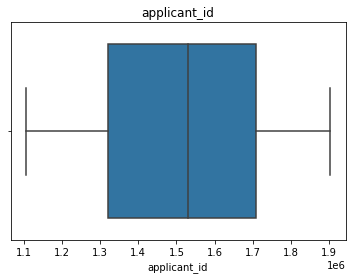

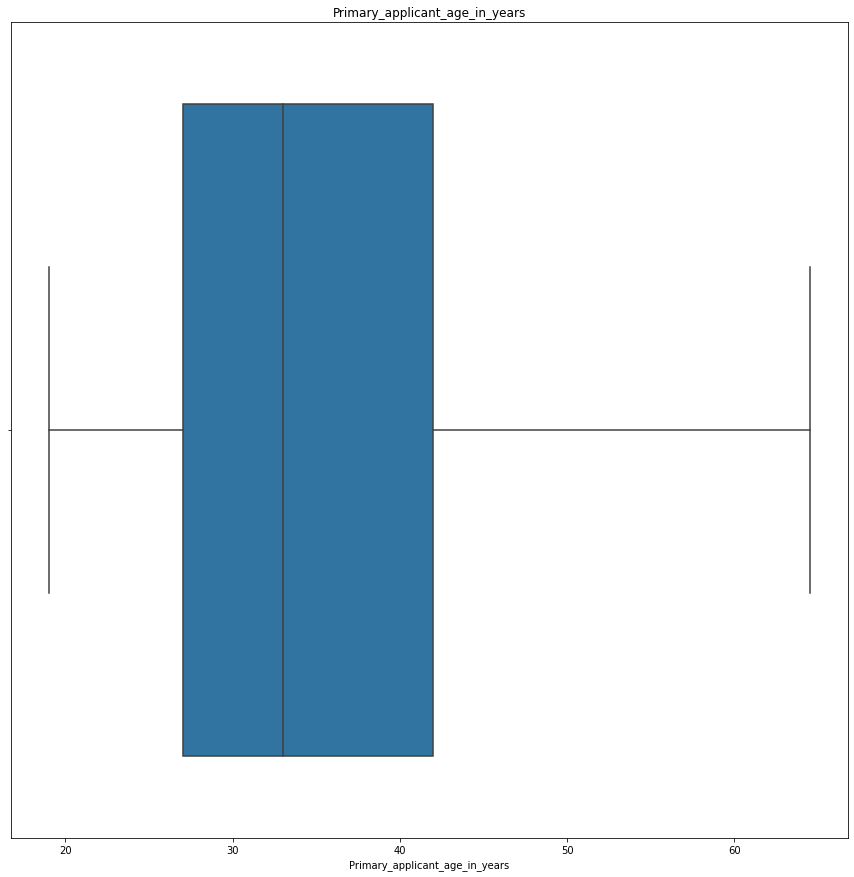

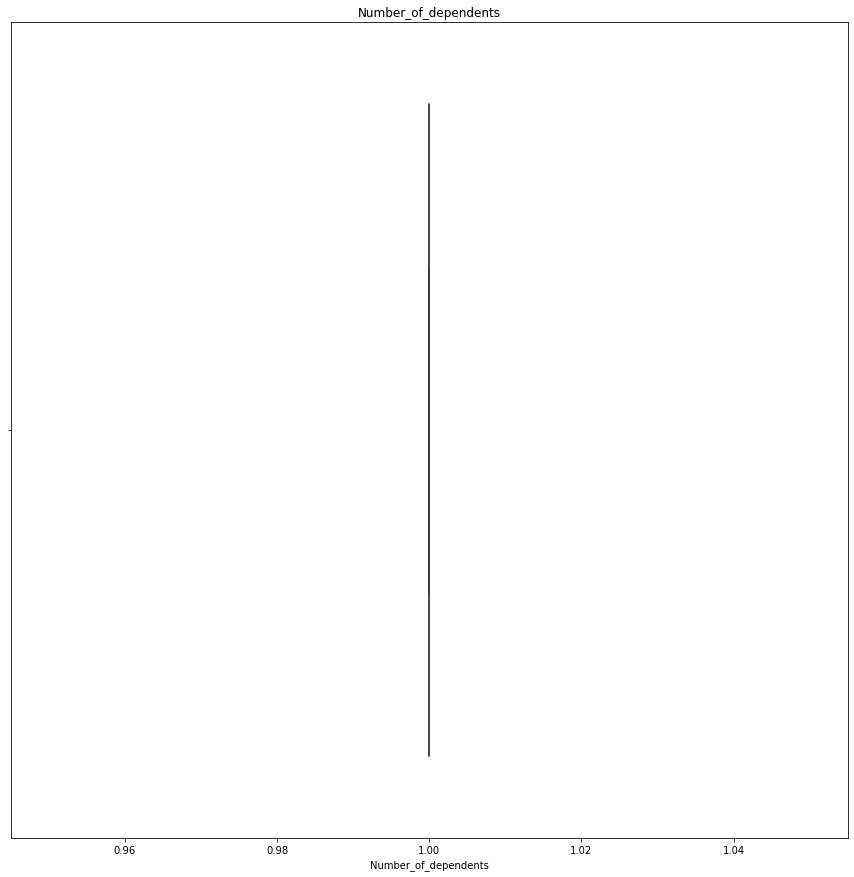

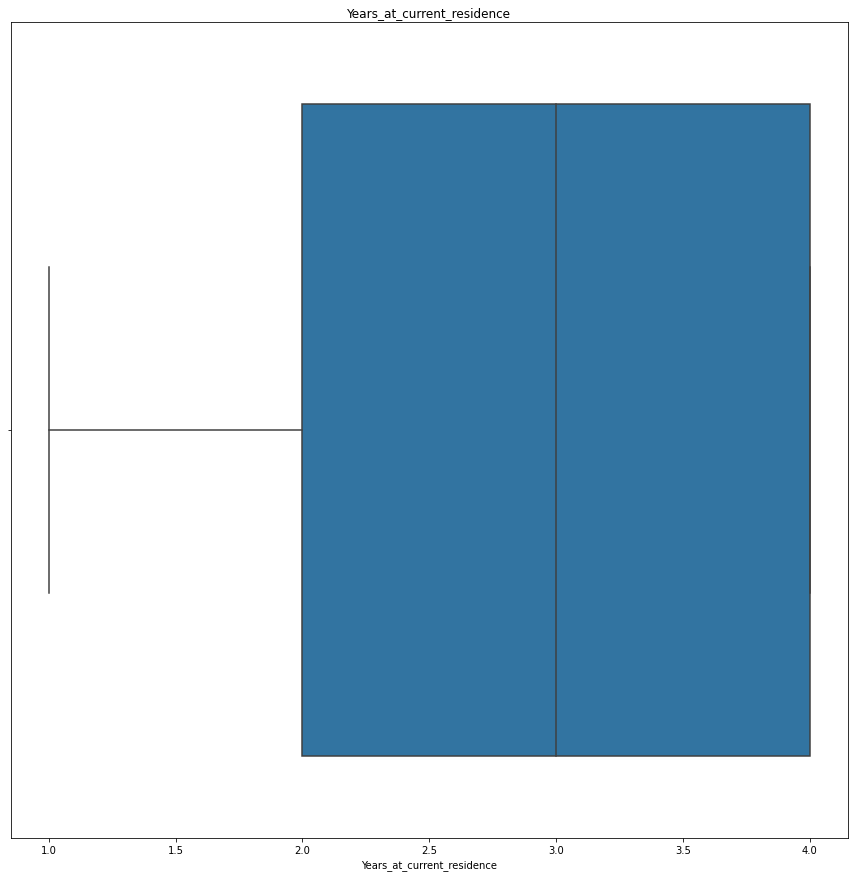

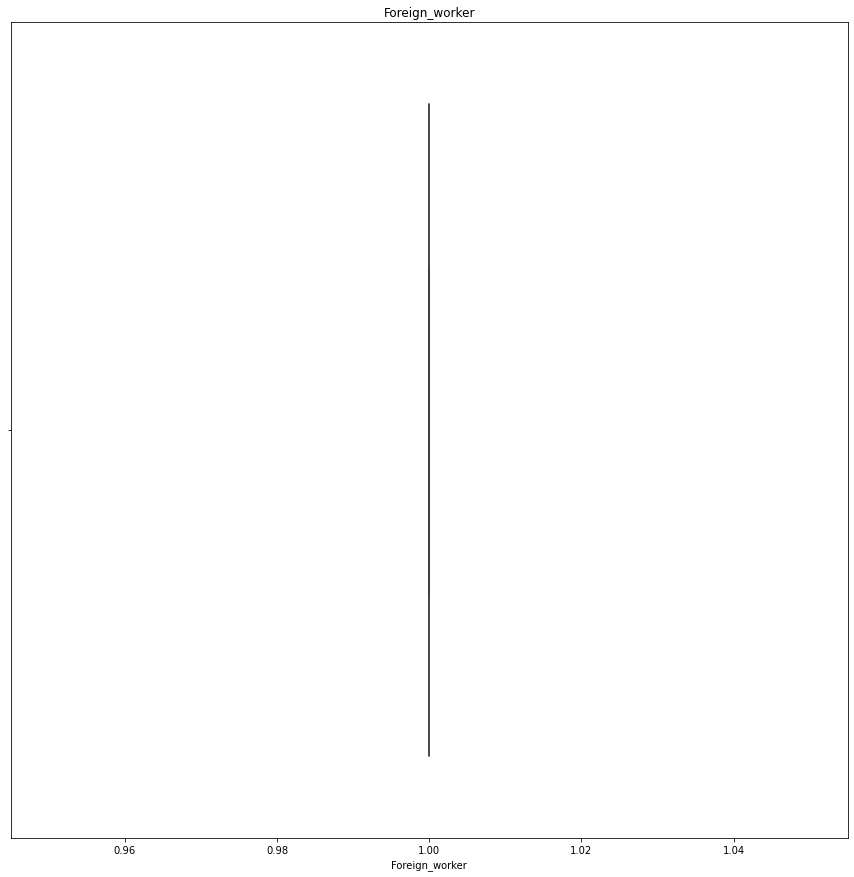

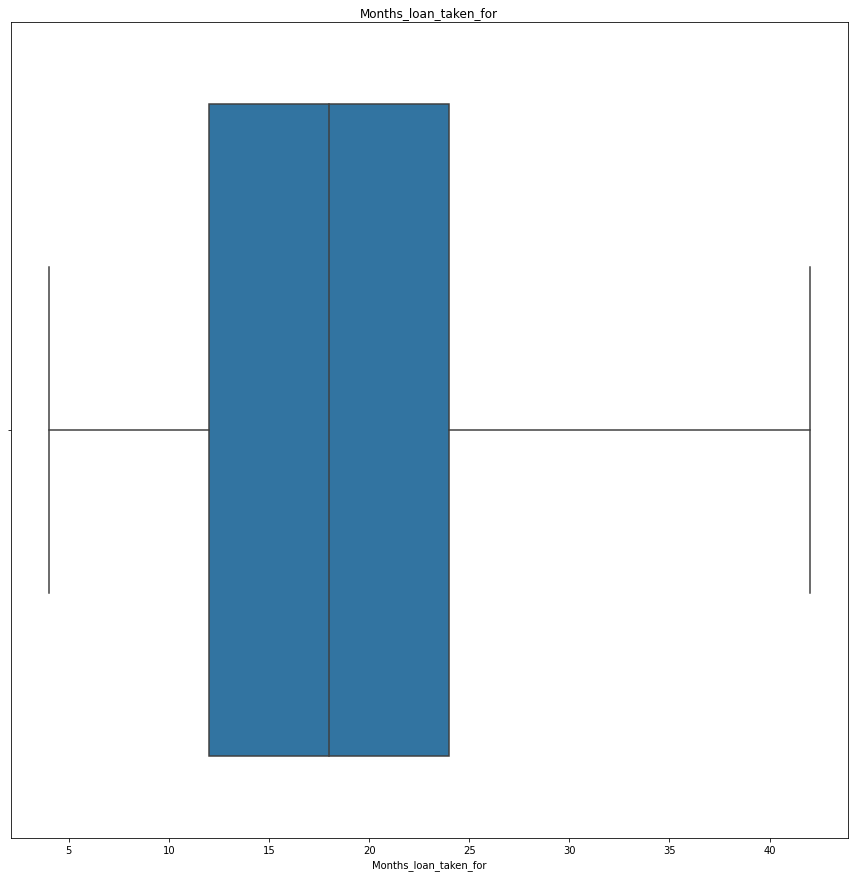

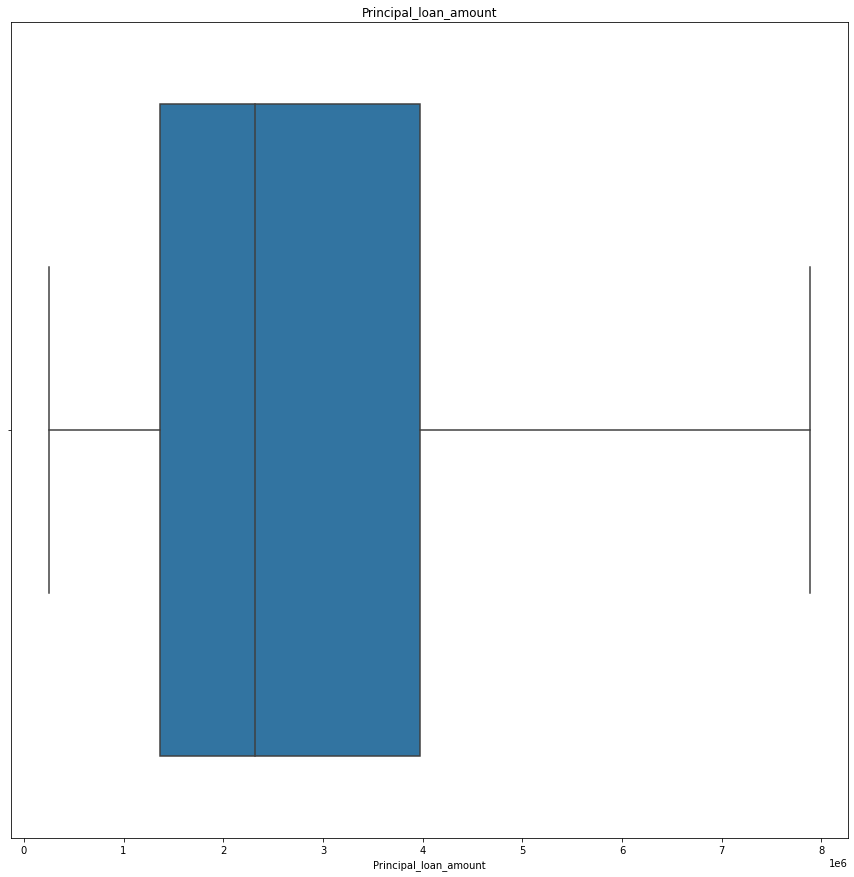

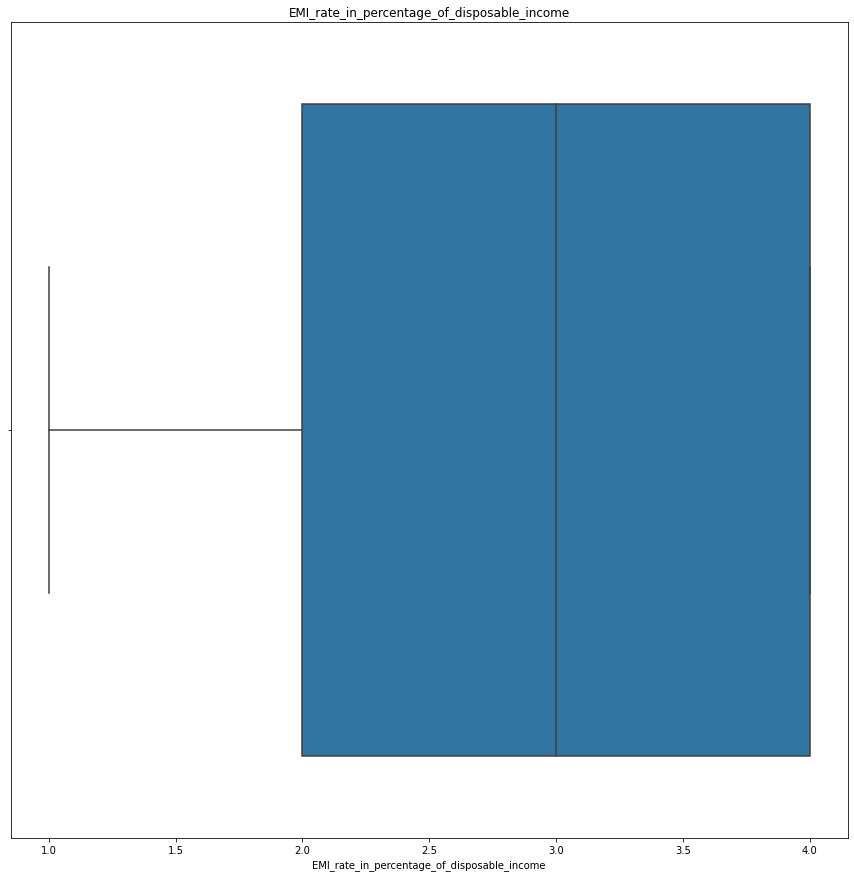

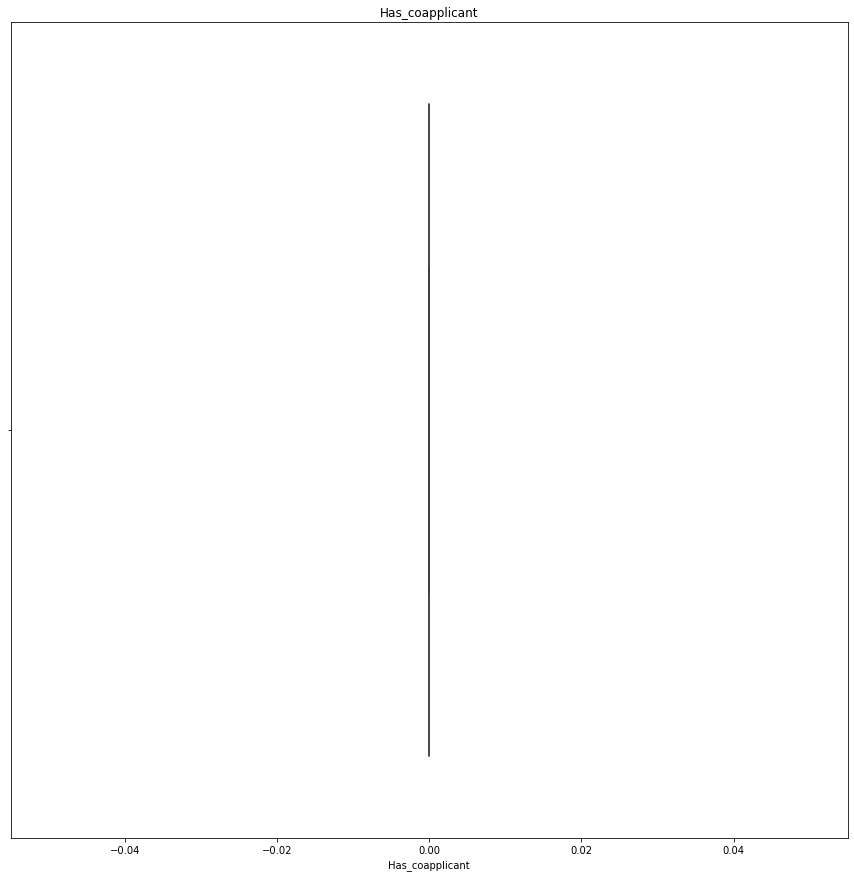

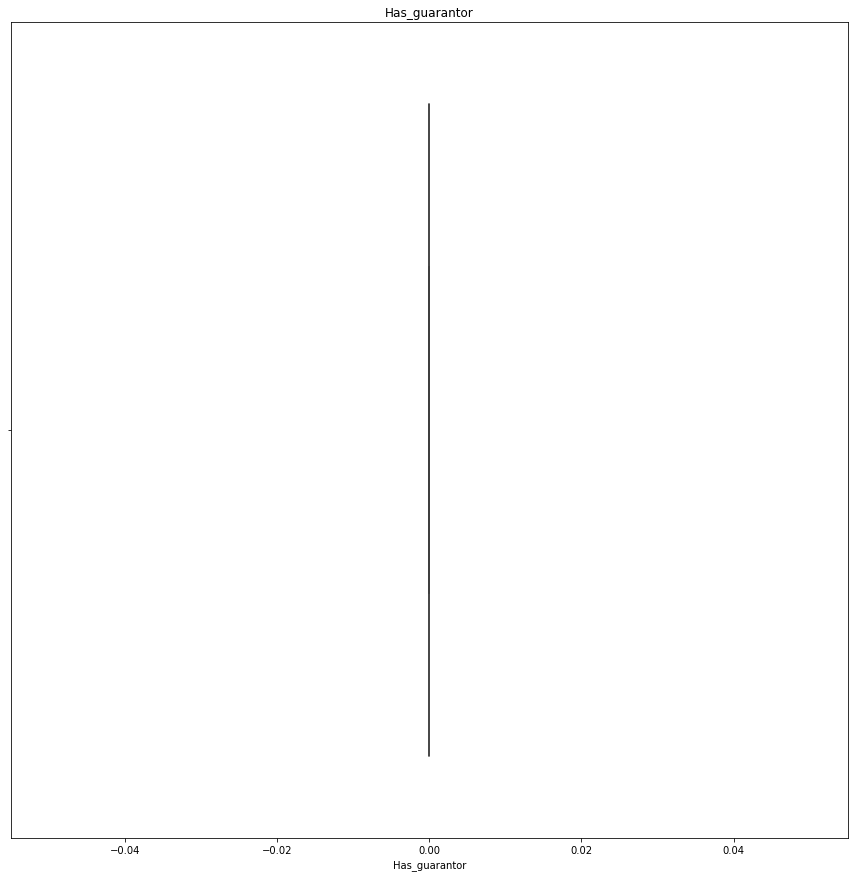

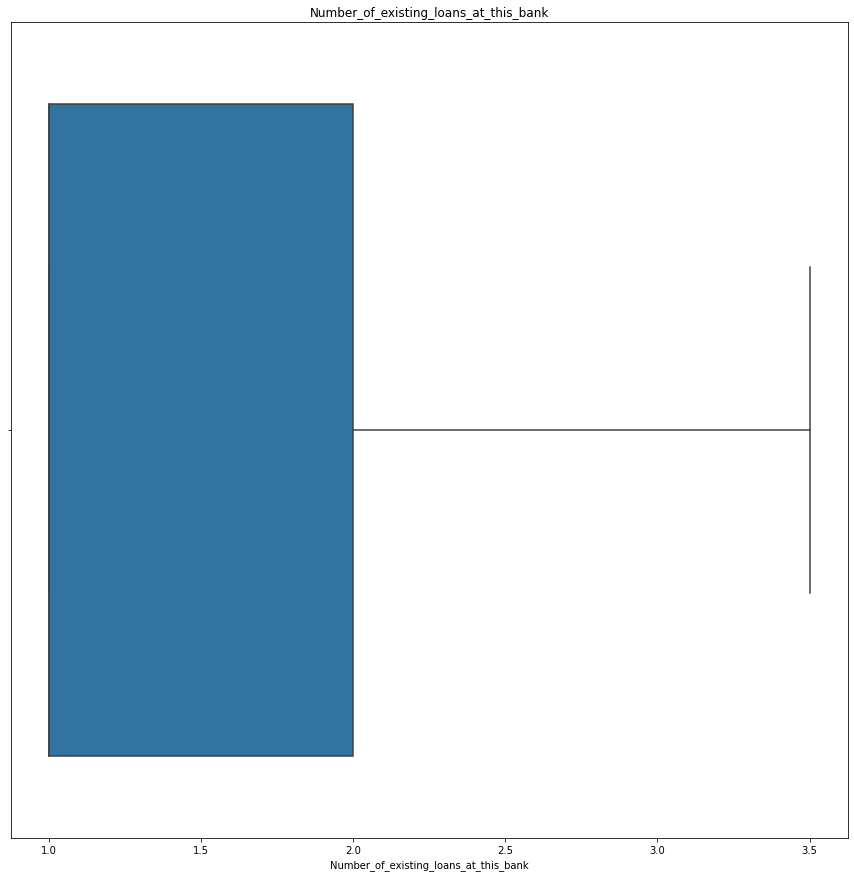

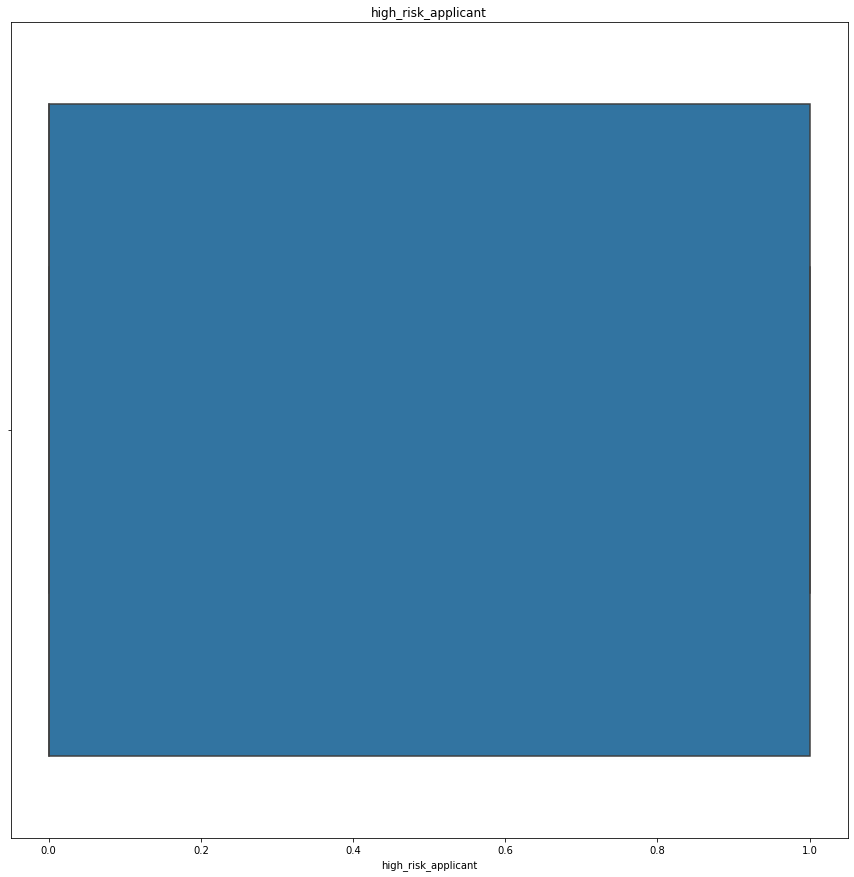

<Figure size 1080x1080 with 0 Axes>

In [16]:
for feature in numerical_feature:
    data=df.copy()
    sns.boxplot(data[feature])
    warnings.filterwarnings("ignore")
    plt.title(feature)
    plt.figure(figsize=(15,15))

## Splitting data into train data and test data

In [17]:
X=df.drop(labels="high_risk_applicant",axis=1)
Y=df[["high_risk_applicant"]]
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.33, random_state=42)

## Using Smote to handle imbalanced dataset

In [18]:
# Resampling the minority class. The strategy can be changed as required.
sm = SMOTE(sampling_strategy='minority', random_state=42)
# Fit the model to generate the data.
oversampled_X_train, oversampled_Y_train = sm.fit_resample(X_train, y_train)
train_data = pd.concat([pd.DataFrame(oversampled_Y_train), pd.DataFrame(oversampled_X_train)], axis=1)
oversampled_X_test, oversampled_Y_test = sm.fit_resample(X_test, y_test)
test_data = pd.concat([pd.DataFrame(oversampled_Y_test), pd.DataFrame(oversampled_X_test)], axis=1)

In [19]:
train_data['high_risk_applicant'].value_counts()

0.0    471
1.0    471
Name: high_risk_applicant, dtype: int64

In [20]:
test_data['high_risk_applicant'].value_counts()

1.0    229
0.0    229
Name: high_risk_applicant, dtype: int64

## Feature Selection(dropping correlated features)

In [21]:
X_train=train_data.drop(labels="high_risk_applicant",axis=1)
Y_train=train_data[["high_risk_applicant"]]
X_test=test_data.drop(labels="high_risk_applicant",axis=1)
Y_test=test_data[["high_risk_applicant"]]

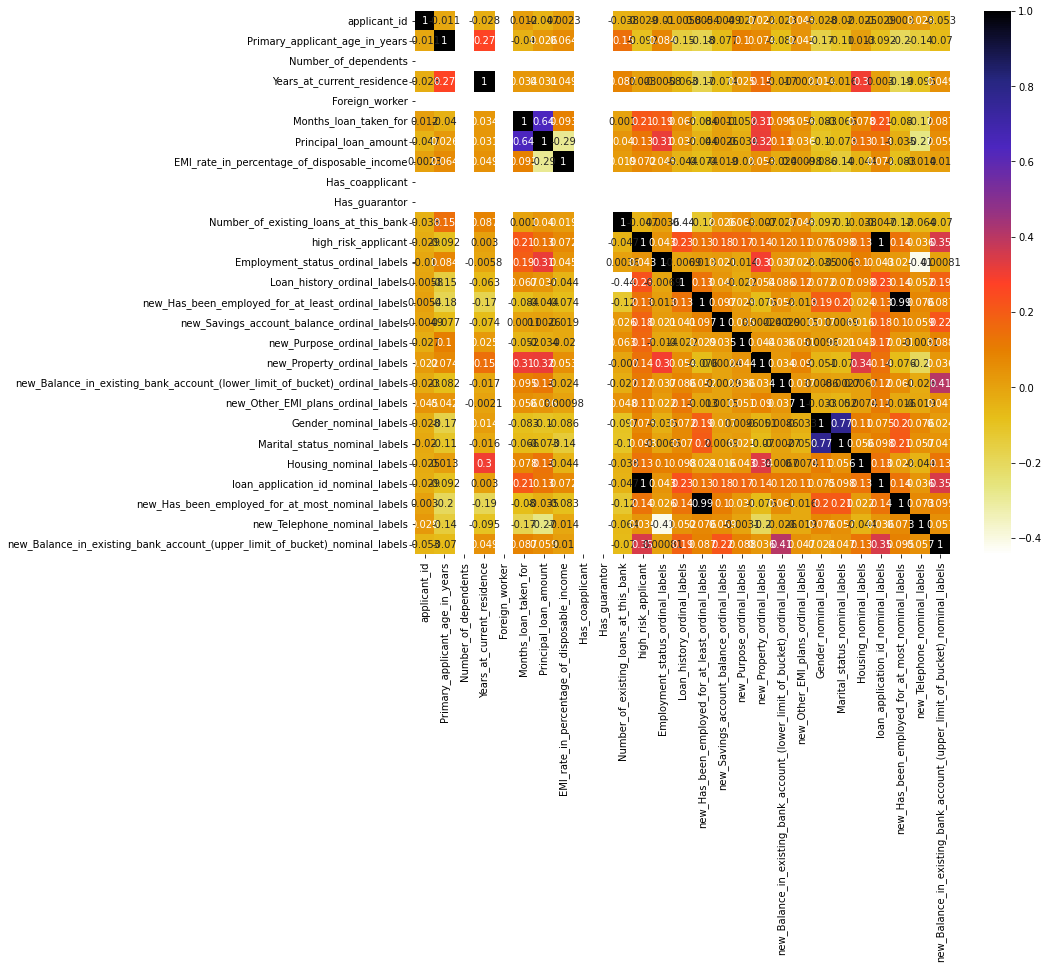

In [22]:
plt.figure(figsize=(12,10))
cor = df.corr()
sns.heatmap(cor, annot=True, cmap=plt.cm.CMRmap_r)
plt.show()

In [23]:
#function to find correlated features above the given threshold 
def correlation(dataset, threshold):
    """
                                Method Name: correlation
                                Description: Finds the correlated features from the dataframe provided and threshold value
                                Outcome: returns a set of correlated features

                                Written By: Saurabh Naik
                                Version: 1.0
                                Revisions: None
        """
    col_corr = set()  # Set of all the names of correlated columns
    corr_matrix = dataset.corr()
    for i in range(len(corr_matrix.columns)):
        for j in range(i):
            if abs(corr_matrix.iloc[i, j]) > threshold: # we are interested in absolute coeff value
                colname = corr_matrix.columns[i]  # getting the name of column
                col_corr.add(colname)
    return col_corr

## Removing 80% correlated features from train data

In [24]:
#threshold=80% that is if they are correlated by 80%
corr_features = correlation(X_train, 0.80)
len(set(corr_features))

1

In [25]:
corr_features

{'new_Has_been_employed_for_at_most_nominal_labels'}

In [26]:
X_train.drop(corr_features,axis=1,inplace=True)

In [27]:
X_train.shape

(942, 25)

## Removing 80% correlated features from test data

In [28]:
#threshold=80% that is if they are correlated by 80%
corr_features = correlation(X_test, 0.80)
len(set(corr_features))

1

In [29]:
corr_features

{'new_Has_been_employed_for_at_most_nominal_labels'}

In [30]:
X_test.drop(corr_features,axis=1,inplace=True)

In [31]:
X_test.shape

(458, 25)

## Removing features having 0 varience using Varience Threshold from train data

In [32]:
var_thres=VarianceThreshold(threshold=0)
var_thres.fit(X_train)

VarianceThreshold(threshold=0)

In [33]:
constant_columns = [column for column in X_train.columns
                    if column not in X_train.columns[var_thres.get_support()]]

print(len(constant_columns))

4


In [34]:
for column in constant_columns:
    print(column)

Number_of_dependents
Foreign_worker
Has_coapplicant
Has_guarantor


In [35]:
X_train.drop(constant_columns,axis=1,inplace=True)

In [36]:
X_train.shape

(942, 21)

## Removing features having 0 varience using Varience Threshold from test data

In [37]:
var_thres=VarianceThreshold(threshold=0)
var_thres.fit(X_test)

VarianceThreshold(threshold=0)

In [38]:
constant_columns = [column for column in X_test.columns
                    if column not in X_test.columns[var_thres.get_support()]]

print(len(constant_columns))

4


In [39]:
for column in constant_columns:
    print(column)

Number_of_dependents
Foreign_worker
Has_coapplicant
Has_guarantor


In [40]:
X_test.drop(constant_columns,axis=1,inplace=True)

In [41]:
X_test.shape

(458, 21)

## Converting into new dataframes after dropping columns

In [42]:
df_final_train=pd.DataFrame(X_train)
df_final_test=pd.DataFrame(X_test)

## Applying Standard scalar to convert data in Standard normal distribution

In [43]:
scaled_features_train = StandardScaler().fit_transform(df_final_train.values)
scaled_features_test = StandardScaler().fit_transform(df_final_test.values)
scaled_features_df_train = pd.DataFrame(scaled_features_train, index=df_final_train.index, columns=df_final_train.columns)
scaled_features_df_test = pd.DataFrame(scaled_features_test, index=df_final_test.index, columns=df_final_test.columns)

In [44]:
scaled_features_df_train['high_risk_applicant']=pd.DataFrame(Y_train)
scaled_features_df_test['high_risk_applicant']=pd.DataFrame(Y_test)

In [45]:
scaled_features_df_train

,applicant_id,Primary_applicant_age_in_years,Years_at_current_residence,Months_loan_taken_for,Principal_loan_amount,EMI_rate_in_percentage_of_disposable_income,Number_of_existing_loans_at_this_bank,Employment_status_ordinal_labels,Loan_history_ordinal_labels,new_Has_been_employed_for_at_least_ordinal_labels,...,new_Property_ordinal_labels,new_Balance_in_existing_bank_account_(lower_limit_of_bucket)_ordinal_labels,new_Other_EMI_plans_ordinal_labels,Gender_nominal_labels,Marital_status_nominal_labels,Housing_nominal_labels,loan_application_id_nominal_labels,new_Telephone_nominal_labels,new_Balance_in_existing_bank_account_(upper_limit_of_bucket)_nominal_labels,high_risk_applicant
0,0.557424,0.609413,-0.709569,0.798508,-0.357832,1.021560,1.079500,-0.125107,-0.447766,-0.615703,...,-0.327480,1.546121,1.074738,-0.753914,-0.834052,-0.704367,-1.0,0.894508,0.453356,0.0
1,1.190640,-0.937876,-1.650996,0.224752,0.916411,1.021560,-0.752123,-0.125107,0.513044,0.189842,...,0.677360,-0.335592,1.074738,-0.753914,-0.834052,-0.704367,-1.0,0.894508,-1.279576,0.0
2,-1.669820,-1.034582,-0.709569,-0.922762,-0.897945,1.021560,-0.752123,-1.236909,0.513044,0.189842,...,-1.332319,-0.335592,-0.454572,1.485090,1.159703,-0.704367,1.0,0.894508,1.138159,1.0
3,0.781418,2.833641,1.173287,-1.209640,0.205156,-1.720062,-0.752123,-1.236909,0.513044,-0.615703,...,-1.332319,-0.335592,-0.454572,-0.753914,-0.834052,-0.704367,-1.0,0.894508,-1.279576,0.0
4,-0.160600,2.881993,1.173287,-1.496518,-0.922939,1.021560,1.079500,-0.125107,-1.408576,-0.615703,...,-1.332319,-0.335592,-0.454572,-0.753914,-0.834052,-0.704367,-1.0,-1.217649,1.138159,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
937,-1.398429,-0.352438,0.231859,-0.444631,-0.811740,0.107686,0.906195,-1.236909,0.513044,-1.421248,...,0.677360,-0.335592,-0.454572,-0.753914,-0.834052,1.519814,1.0,0.894508,1.073364,1.0
938,1.722179,0.213361,0.231859,0.129126,-0.898041,1.021560,0.912297,-0.125107,-1.408576,0.995387,...,0.677360,-0.335592,2.604047,-0.753914,-0.822695,-0.704367,1.0,0.894508,0.515870,1.0
939,-1.140673,-0.403132,0.231859,-0.922762,-1.096887,1.021560,0.494637,-0.125107,-1.408576,-1.421248,...,-0.327480,-0.335592,-0.454572,-0.753914,-0.794326,-0.007436,1.0,0.894508,1.138159,1.0
940,-0.372739,-0.747119,-0.709569,1.467891,0.675706,-0.806188,0.988032,-0.125107,-1.408576,-1.421248,...,-1.332319,1.546121,-0.454572,-0.642102,-0.734488,-0.581688,1.0,0.789031,0.453356,1.0


In [46]:
scaled_features_df_test

,applicant_id,Primary_applicant_age_in_years,Years_at_current_residence,Months_loan_taken_for,Principal_loan_amount,EMI_rate_in_percentage_of_disposable_income,Number_of_existing_loans_at_this_bank,Employment_status_ordinal_labels,Loan_history_ordinal_labels,new_Has_been_employed_for_at_least_ordinal_labels,...,new_Property_ordinal_labels,new_Balance_in_existing_bank_account_(lower_limit_of_bucket)_ordinal_labels,new_Other_EMI_plans_ordinal_labels,Gender_nominal_labels,Marital_status_nominal_labels,Housing_nominal_labels,loan_application_id_nominal_labels,new_Telephone_nominal_labels,new_Balance_in_existing_bank_account_(upper_limit_of_bucket)_nominal_labels,high_risk_applicant
0,-0.869631,-1.094891,-0.719592,-0.243755,0.125848,-0.877070,-0.728898,0.050902,0.485748,0.162714,...,-1.306515,-0.263655,-0.539013,1.665180,1.104589,-0.701427,1.0,0.774916,1.047661,1.0
1,-0.425543,-0.107081,1.163683,-0.243755,0.711139,0.042148,-0.728898,-1.176099,0.485748,0.162714,...,0.678174,-0.263655,-0.539013,-0.661801,-0.810336,-0.701427,-1.0,-1.408901,1.047661,0.0
2,1.443288,-0.376484,0.222046,0.338714,-0.299594,-0.877070,-0.728898,0.050902,1.474516,-1.475151,...,0.678174,-0.263655,2.382499,-0.661801,-0.810336,-0.701427,-1.0,0.774916,1.047661,0.0
3,-0.694690,-1.184692,1.163683,-0.826224,-0.805207,0.042148,-0.728898,0.050902,0.485748,0.162714,...,-1.306515,-2.243225,-0.539013,-0.661801,-0.690846,1.472566,-1.0,0.774916,-1.279856,0.0
4,0.678954,-0.107081,-0.719592,1.212417,2.124198,0.042148,1.243966,2.504903,-1.491787,-1.475151,...,0.678174,-0.263655,-0.539013,-0.661801,-0.810336,-0.701427,-1.0,-1.408901,-1.279856,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
453,1.403893,-0.909570,-0.719592,1.406574,0.752661,0.042148,1.243966,1.277902,-1.491787,-0.656219,...,-0.314170,-0.263655,-0.539013,-0.661801,-0.810336,-0.693283,1.0,-1.408901,-1.271137,1.0
454,1.378209,0.927056,0.222046,0.338714,-0.197452,0.961365,1.175743,-1.176099,-0.503019,-0.656219,...,0.678174,-0.263655,-0.539013,-0.661801,-0.810336,-0.626249,1.0,0.774916,-1.222166,1.0
455,1.467492,-0.862941,1.163683,0.921183,-0.379340,0.042148,-0.728898,-1.176099,0.485748,0.162714,...,-0.314170,-0.263655,-0.539013,-0.661801,0.865990,1.472566,1.0,0.774916,1.047661,1.0
456,-0.681100,-0.086002,0.222046,-1.214537,-0.845471,0.961365,-0.497355,-1.176099,0.485748,-1.475151,...,0.678174,-2.243225,-0.539013,1.392077,0.879846,1.458335,1.0,0.774916,0.774495,1.0


## Checking distribution of train data

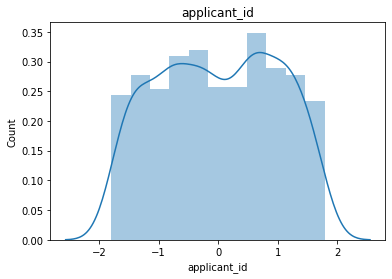

<Figure size 1080x1080 with 0 Axes>

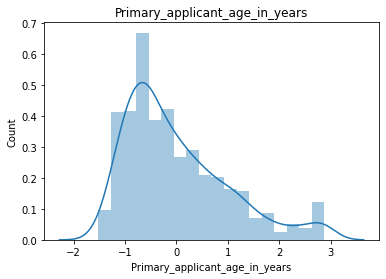

<Figure size 1080x1080 with 0 Axes>

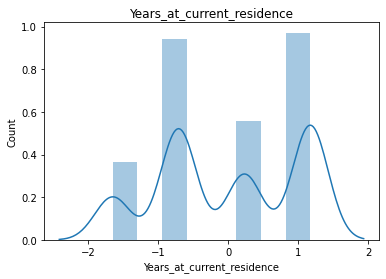

<Figure size 1080x1080 with 0 Axes>

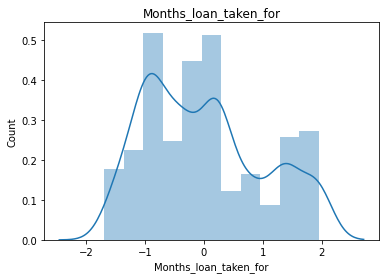

<Figure size 1080x1080 with 0 Axes>

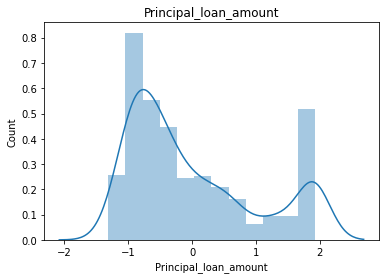

<Figure size 1080x1080 with 0 Axes>

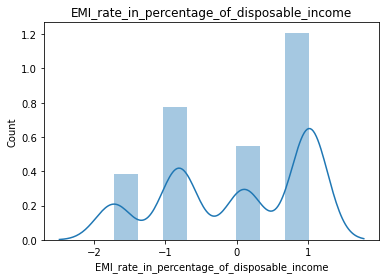

<Figure size 1080x1080 with 0 Axes>

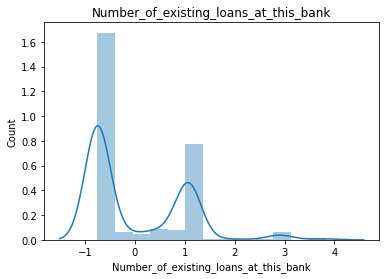

<Figure size 1080x1080 with 0 Axes>

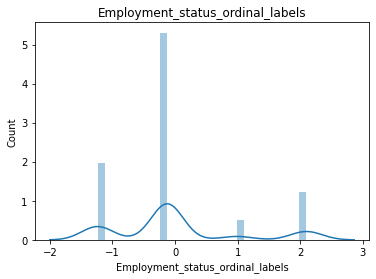

<Figure size 1080x1080 with 0 Axes>

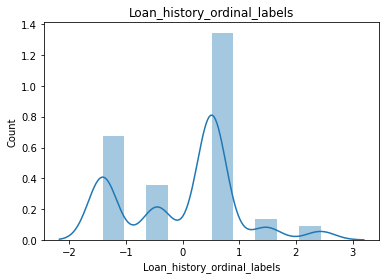

<Figure size 1080x1080 with 0 Axes>

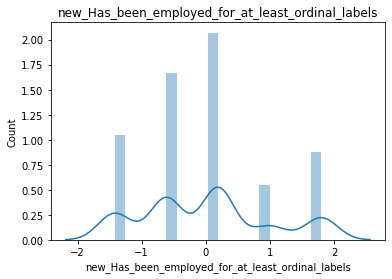

<Figure size 1080x1080 with 0 Axes>

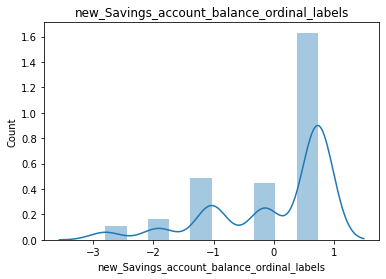

<Figure size 1080x1080 with 0 Axes>

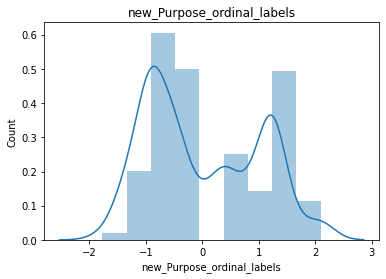

<Figure size 1080x1080 with 0 Axes>

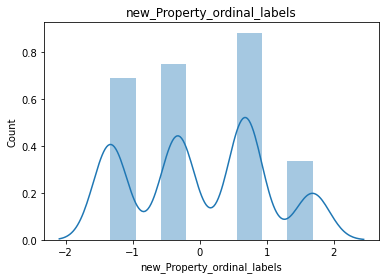

<Figure size 1080x1080 with 0 Axes>

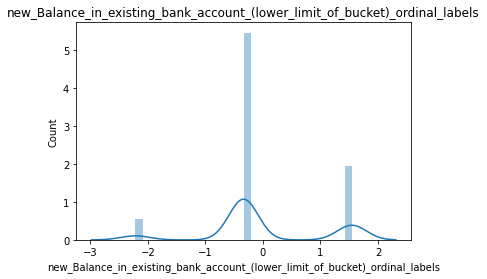

<Figure size 1080x1080 with 0 Axes>

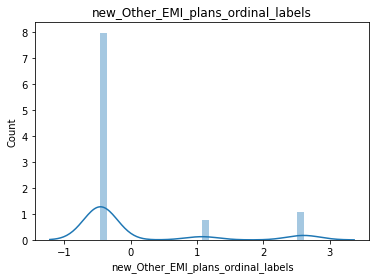

<Figure size 1080x1080 with 0 Axes>

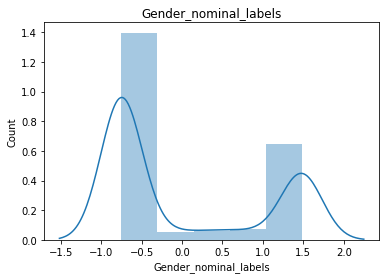

<Figure size 1080x1080 with 0 Axes>

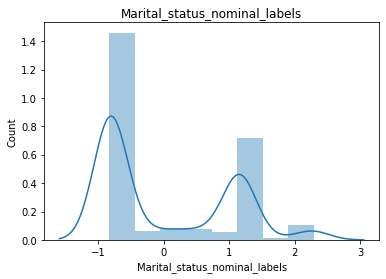

<Figure size 1080x1080 with 0 Axes>

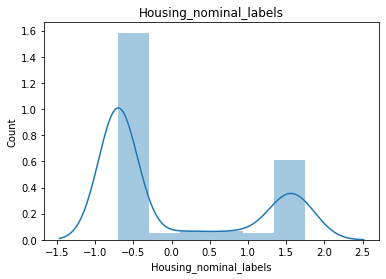

<Figure size 1080x1080 with 0 Axes>

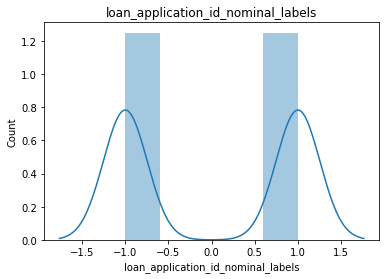

<Figure size 1080x1080 with 0 Axes>

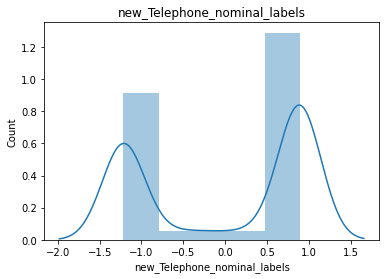

<Figure size 1080x1080 with 0 Axes>

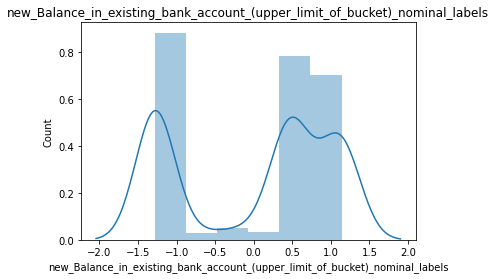

<Figure size 1080x1080 with 0 Axes>

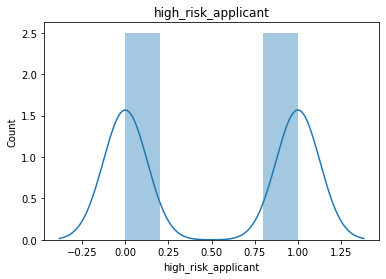

<Figure size 1080x1080 with 0 Axes>

In [47]:
for feature in scaled_features_df_train.columns:
    sns.distplot(scaled_features_df_train[feature])
    plt.xlabel(feature)
    plt.ylabel("Count")
    plt.title(feature)
    plt.figure(figsize=(15,15))
    plt.show()

## Checking distribution of test data

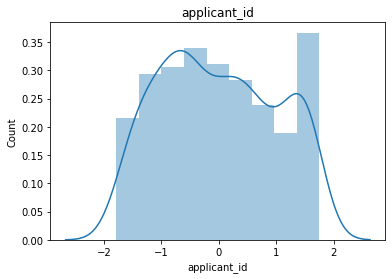

<Figure size 1080x1080 with 0 Axes>

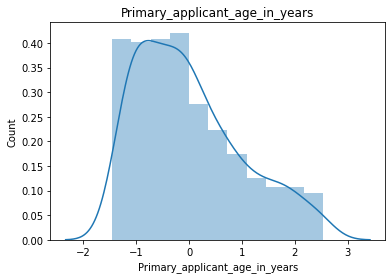

<Figure size 1080x1080 with 0 Axes>

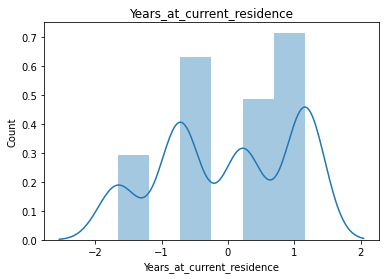

<Figure size 1080x1080 with 0 Axes>

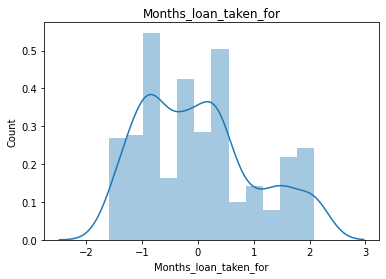

<Figure size 1080x1080 with 0 Axes>

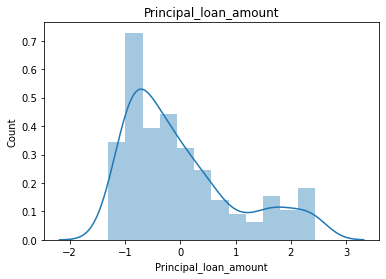

<Figure size 1080x1080 with 0 Axes>

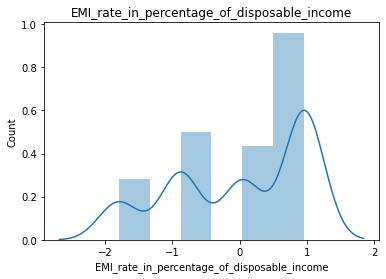

<Figure size 1080x1080 with 0 Axes>

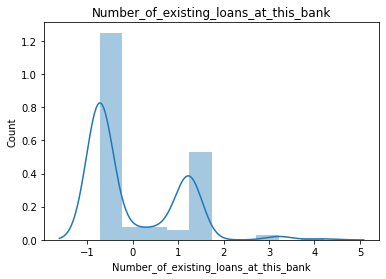

<Figure size 1080x1080 with 0 Axes>

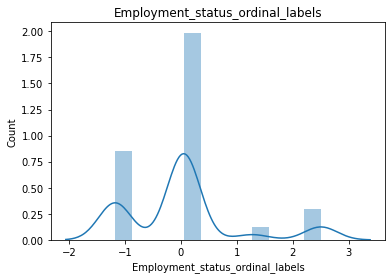

<Figure size 1080x1080 with 0 Axes>

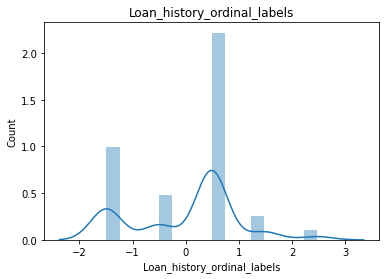

<Figure size 1080x1080 with 0 Axes>

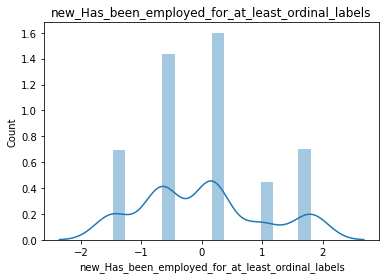

<Figure size 1080x1080 with 0 Axes>

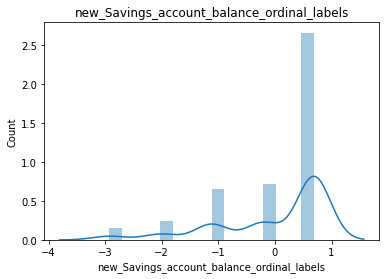

<Figure size 1080x1080 with 0 Axes>

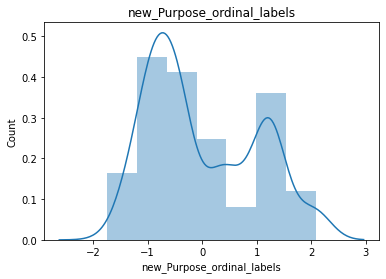

<Figure size 1080x1080 with 0 Axes>

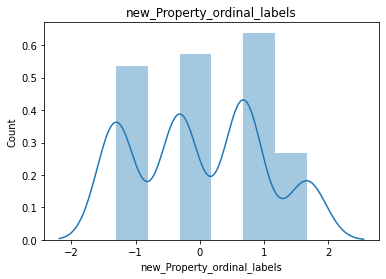

<Figure size 1080x1080 with 0 Axes>

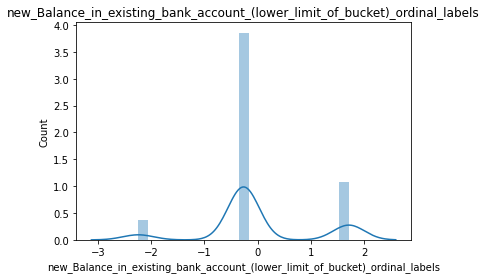

<Figure size 1080x1080 with 0 Axes>

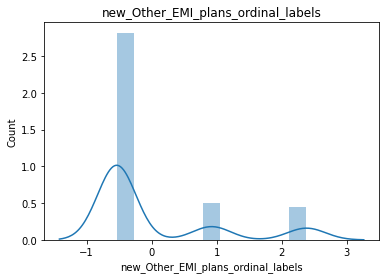

<Figure size 1080x1080 with 0 Axes>

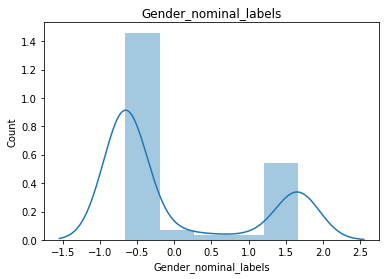

<Figure size 1080x1080 with 0 Axes>

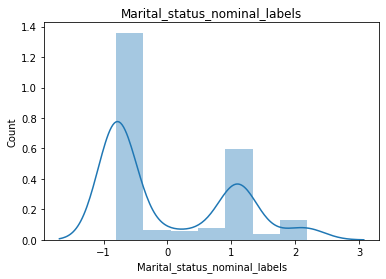

<Figure size 1080x1080 with 0 Axes>

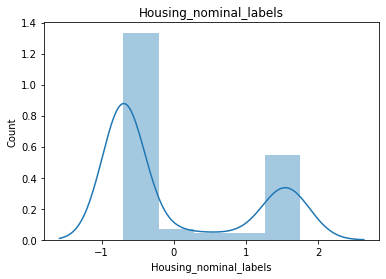

<Figure size 1080x1080 with 0 Axes>

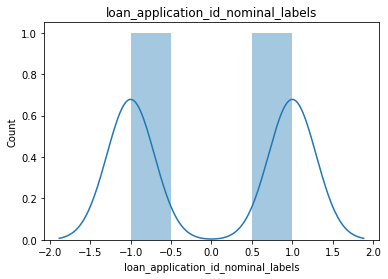

<Figure size 1080x1080 with 0 Axes>

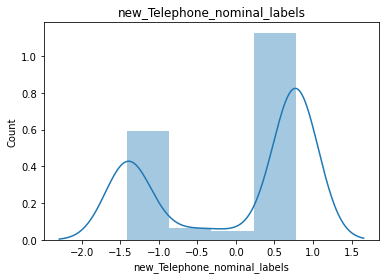

<Figure size 1080x1080 with 0 Axes>

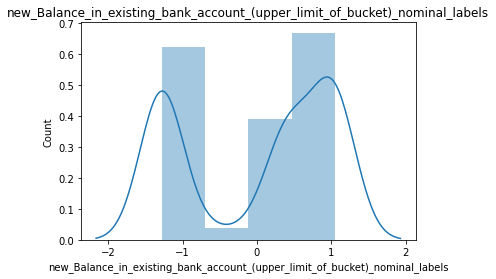

<Figure size 1080x1080 with 0 Axes>

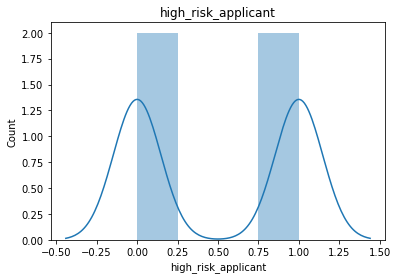

<Figure size 1080x1080 with 0 Axes>

In [48]:
for feature in scaled_features_df_test.columns:
    sns.distplot(scaled_features_df_test[feature])
    plt.xlabel(feature)
    plt.ylabel("Count")
    plt.title(feature)
    plt.figure(figsize=(15,15))
    plt.show()

## With this Data preprocessing is completed and we can move towards model building and hyperparameter tuning

In [49]:
#Grabbing X and Y:
X_train=scaled_features_df_train.drop(labels="high_risk_applicant",axis=1)
X_test=scaled_features_df_test.drop(labels="high_risk_applicant",axis=1)
y_train=scaled_features_df_train[["high_risk_applicant"]]
y_test=scaled_features_df_test[["high_risk_applicant"]]

## Logistic Regression using Optuna Library

In [53]:
#Step 1. Define an objective function to be maximized.
def objective(trial):
    """
                                Method Name: objective
                                Description: This function selects a ML classifiers and takes a variety of hyperparameter 
                                in different ranges and then depending on the scoring metrics maximizes this metrics and returns
                                the hyperparameter that provided these better metrics
                                Outcome: We get the best hyperparameters of the model
                            

                                Written By: Saurabh Naik
                                Version: 1.0
                                Revisions: None
        """

    classifier_name = 'LogReg'
    
    # Step 2. Setup values for the hyperparameters:
    if classifier_name == 'LogReg':
        penalty = trial.suggest_categorical('penalty', ['l2', 'l1'])
        if penalty == 'l1':
            solver = 'saga'
        else:
            solver = 'lbfgs'
        C = trial.suggest_uniform('C', 0.01, 10)
        classifier_obj = linear_model.LogisticRegression(penalty=penalty, C=C, solver=solver)

    # Step 3: Scoring method:
    score = model_selection.cross_val_score(classifier_obj, X_train, y_train, cv=3,scoring='recall')
    recall = score.mean()
    return recall

# Step 4: Running it
study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=10)

[I 2022-09-16 19:23:18,926] A new study created in memory with name: no-name-e9d5a64c-9c23-4291-bb78-4d051fdf8821
[I 2022-09-16 19:23:19,043] Trial 0 finished with value: 1.0 and parameters: {'penalty': 'l2', 'C': 3.391951905407835}. Best is trial 0 with value: 1.0.
[I 2022-09-16 19:23:19,135] Trial 1 finished with value: 1.0 and parameters: {'penalty': 'l2', 'C': 5.165996654089062}. Best is trial 0 with value: 1.0.
[I 2022-09-16 19:23:19,336] Trial 2 finished with value: 1.0 and parameters: {'penalty': 'l1', 'C': 3.0731856233973858}. Best is trial 0 with value: 1.0.
[I 2022-09-16 19:23:19,552] Trial 3 finished with value: 1.0 and parameters: {'penalty': 'l1', 'C': 5.28078016138273}. Best is trial 0 with value: 1.0.
[I 2022-09-16 19:23:19,689] Trial 4 finished with value: 1.0 and parameters: {'penalty': 'l2', 'C': 0.7217628016915199}. Best is trial 0 with value: 1.0.
[I 2022-09-16 19:23:19,777] Trial 5 finished with value: 1.0 and parameters: {'penalty': 'l2', 'C': 5.419575454589355}. 

## Finding best parameter of the study

In [54]:
trial = study.best_trial
trial.params

{'penalty': 'l2', 'C': 3.391951905407835}

## Training on best parameters

In [55]:
lr=linear_model.LogisticRegression(penalty=trial.params['penalty'],C=trial.params['C'])
lr.fit(X_train,y_train)

LogisticRegression(C=3.391951905407835)

## Evaluation reports

In [56]:
y_pred=lr.predict(X_test)
print(confusion_matrix(y_test,y_pred))
print(accuracy_score(y_test,y_pred))
print(classification_report(y_test,y_pred))

[[229   0]
 [  0 229]]
1.0
              precision    recall  f1-score   support

         0.0       1.00      1.00      1.00       229
         1.0       1.00      1.00      1.00       229

    accuracy                           1.00       458
   macro avg       1.00      1.00      1.00       458
weighted avg       1.00      1.00      1.00       458



## Random Forest Using Optuna

In [57]:
def objective(trial):
    """
                                Method Name: objective
                                Description: This function selects a ML classifiers and takes a variety of hyperparameter 
                                in different ranges and then depending on the scoring metrics maximizes this metrics and returns
                                the hyperparameter that provided these better metrics
                                Outcome: We get the best hyperparameters of the model
                            

                                Written By: Saurabh Naik
                                Version: 1.0
                                Revisions: None
        """

    classifier_name = 'RandomForest'
    
    # Step 2. Setup values for the hyperparameters:
    if classifier_name == 'RandomForest':
        n_estimators = trial.suggest_int('n_estimators', 200, 2000,10)
        max_depth = int(trial.suggest_float('max_depth', 10, 100, log=True))
        criterion = trial.suggest_categorical('criterion', ['entropy','gini'])
        min_samples_split = trial.suggest_int('min_samples_split', 2, 20)
        min_samples_leaf = trial.suggest_int('min_samples_leaf', 2, 20)
        classifier_obj = sklearn.ensemble.RandomForestClassifier(
            n_estimators=n_estimators,criterion=criterion, max_depth=max_depth,min_samples_split=min_samples_split
            ,min_samples_leaf=min_samples_leaf)

    # Step 3: Scoring method:
    score = model_selection.cross_val_score(classifier_obj, X_train, y_train, cv=3,scoring='recall')
    recall = score.mean()
    return recall

# Step 4: Running it
study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=10)

[I 2022-09-16 19:23:25,301] A new study created in memory with name: no-name-5b83b2a5-3501-4d13-8ae5-07b7c1813feb
[I 2022-09-16 19:23:51,110] Trial 0 finished with value: 0.9808917197452228 and parameters: {'n_estimators': 2000, 'max_depth': 22.231898125255057, 'criterion': 'gini', 'min_samples_split': 9, 'min_samples_leaf': 20}. Best is trial 0 with value: 0.9808917197452228.
[I 2022-09-16 19:24:17,368] Trial 1 finished with value: 1.0 and parameters: {'n_estimators': 1940, 'max_depth': 33.99024575151209, 'criterion': 'entropy', 'min_samples_split': 3, 'min_samples_leaf': 2}. Best is trial 1 with value: 1.0.
[I 2022-09-16 19:24:40,301] Trial 2 finished with value: 0.989384288747346 and parameters: {'n_estimators': 1860, 'max_depth': 24.00066739522138, 'criterion': 'gini', 'min_samples_split': 10, 'min_samples_leaf': 20}. Best is trial 1 with value: 1.0.
[I 2022-09-16 19:25:06,171] Trial 3 finished with value: 0.9851380042462846 and parameters: {'n_estimators': 1970, 'max_depth': 31.86

## Finding important hyperparameter during training

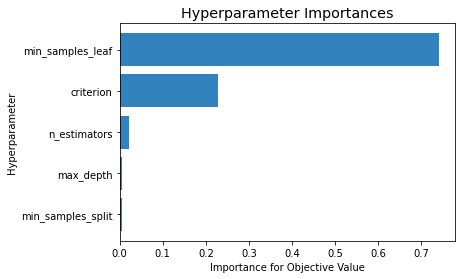

In [58]:
plot_param_importances(study);

## Finding best parameter of the study

In [59]:
trial = study.best_trial
trial.params

{'n_estimators': 1940,
 'max_depth': 33.99024575151209,
 'criterion': 'entropy',
 'min_samples_split': 3,
 'min_samples_leaf': 2}

## Training model with best parameters

In [60]:
rf=sklearn.ensemble.RandomForestClassifier(
            n_estimators=trial.params['n_estimators'],criterion=trial.params['criterion'], 
            max_depth=trial.params['max_depth'],min_samples_split=trial.params['min_samples_split']
            ,min_samples_leaf=trial.params['min_samples_leaf'])
rf.fit(X_train,y_train)

RandomForestClassifier(criterion='entropy', max_depth=33.99024575151209,
                       min_samples_leaf=2, min_samples_split=3,
                       n_estimators=1940)

## Evaluation report

In [61]:
y_pred=rf.predict(X_test)
print(confusion_matrix(y_test,y_pred))
print(accuracy_score(y_test,y_pred))
print(classification_report(y_test,y_pred))

[[229   0]
 [  0 229]]
1.0
              precision    recall  f1-score   support

         0.0       1.00      1.00      1.00       229
         1.0       1.00      1.00      1.00       229

    accuracy                           1.00       458
   macro avg       1.00      1.00      1.00       458
weighted avg       1.00      1.00      1.00       458



## SVC using optuna

In [62]:
#Step 1. Define an objective function to be maximized.
def objective(trial):
    """
                                Method Name: objective
                                Description: This function selects a ML classifiers and takes a variety of hyperparameter 
                                in different ranges and then depending on the scoring metrics maximizes this metrics and returns
                                the hyperparameter that provided these better metrics
                                Outcome: We get the best hyperparameters of the model
                            

                                Written By: Saurabh Naik
                                Version: 1.0
                                Revisions: None
        """

    classifier_name = 'SVC'
    
    # Step 2. Setup values for the hyperparameters:
    if classifier_name == 'SVC':
        kernel = trial.suggest_categorical('kernel', ['linear', 'poly', 'rbf', 'sigmoid'])
        C = trial.suggest_uniform('C', 0.01, 10)
        degree = trial.suggest_discrete_uniform('degree', 1, 5, 1)
        classifier_obj = sklearn.svm.SVC(kernel=kernel,C=C,degree=degree )

    # Step 3: Scoring method:
    score = model_selection.cross_val_score(classifier_obj, X_train, y_train, cv=3,scoring='recall')
    recall = score.mean()
    return recall

# Step 4: Running it
study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=10)

[I 2022-09-16 19:27:15,639] A new study created in memory with name: no-name-67141ca3-6961-4ef0-aa40-8fdb12f2a328
[I 2022-09-16 19:27:15,854] Trial 0 finished with value: 0.9278131634819533 and parameters: {'kernel': 'poly', 'C': 4.029818875145794, 'degree': 4.0}. Best is trial 0 with value: 0.9278131634819533.
[I 2022-09-16 19:27:16,103] Trial 1 finished with value: 0.9978768577494691 and parameters: {'kernel': 'rbf', 'C': 9.567354725429214, 'degree': 4.0}. Best is trial 1 with value: 0.9978768577494691.
[I 2022-09-16 19:27:16,286] Trial 2 finished with value: 0.9978768577494691 and parameters: {'kernel': 'rbf', 'C': 9.488434191243364, 'degree': 4.0}. Best is trial 1 with value: 0.9978768577494691.
[I 2022-09-16 19:27:16,583] Trial 3 finished with value: 0.9978768577494691 and parameters: {'kernel': 'rbf', 'C': 9.815477799209976, 'degree': 2.0}. Best is trial 1 with value: 0.9978768577494691.
[I 2022-09-16 19:27:16,674] Trial 4 finished with value: 0.9808917197452228 and parameters: {

## Finding important parameters during training

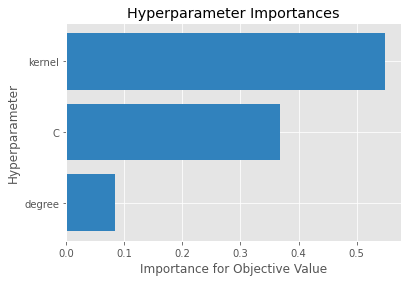

In [63]:
plot_param_importances(study);

## Finding best parameter of the study

In [64]:
trial = study.best_trial
trial.params

{'kernel': 'linear', 'C': 4.597775731672147, 'degree': 2.0}

## Training model with best hyperparameter

In [65]:
svc=sklearn.svm.SVC(kernel=trial.params['kernel'],C=trial.params['C'],degree=trial.params['degree'] )
svc.fit(X_train,y_train)

SVC(C=4.597775731672147, degree=2.0, kernel='linear')

## Evaluation metrics

In [66]:
y_pred=svc.predict(X_test)
print(confusion_matrix(y_test,y_pred))
print(accuracy_score(y_test,y_pred))
print(classification_report(y_test,y_pred))


[[229   0]
 [  0 229]]
1.0
              precision    recall  f1-score   support

         0.0       1.00      1.00      1.00       229
         1.0       1.00      1.00      1.00       229

    accuracy                           1.00       458
   macro avg       1.00      1.00      1.00       458
weighted avg       1.00      1.00      1.00       458



## Naive Bayes using Optuna

In [67]:
def objective(trial):
    """
                                Method Name: objective
                                Description: This function selects a ML classifiers and takes a variety of hyperparameter 
                                in different ranges and then depending on the scoring metrics maximizes this metrics and returns
                                the hyperparameter that provided these better metrics
                                Outcome: We get the best hyperparameters of the model
                            

                                Written By: Saurabh Naik
                                Version: 1.0
                                Revisions: None
        """

    classifier_name = 'NaiveBayes'
    
    # Step 2. Setup values for the hyperparameters:
    if classifier_name == 'NaiveBayes':
        var_smoothing=trial.suggest_float("var_smoothing", 1e-4, 0.3, log=True)
        classifier_obj = sklearn.naive_bayes.GaussianNB(var_smoothing=var_smoothing)

    # Step 3: Scoring method:
    score = model_selection.cross_val_score(classifier_obj, X_train, y_train, cv=3,scoring='recall')
    recall = score.mean()
    return recall

# Step 4: Running it
study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=10)

[I 2022-09-16 19:27:18,156] A new study created in memory with name: no-name-9ea1c653-8dea-42ff-8109-0d8537c9a49a
[I 2022-09-16 19:27:18,243] Trial 0 finished with value: 1.0 and parameters: {'var_smoothing': 0.015474297853980527}. Best is trial 0 with value: 1.0.
[I 2022-09-16 19:27:18,320] Trial 1 finished with value: 1.0 and parameters: {'var_smoothing': 0.04605504021712544}. Best is trial 0 with value: 1.0.
[I 2022-09-16 19:27:18,392] Trial 2 finished with value: 1.0 and parameters: {'var_smoothing': 0.0001201942319631821}. Best is trial 0 with value: 1.0.
[I 2022-09-16 19:27:18,442] Trial 3 finished with value: 1.0 and parameters: {'var_smoothing': 0.0014140580161719134}. Best is trial 0 with value: 1.0.
[I 2022-09-16 19:27:18,480] Trial 4 finished with value: 1.0 and parameters: {'var_smoothing': 0.01715904778897051}. Best is trial 0 with value: 1.0.
[I 2022-09-16 19:27:18,511] Trial 5 finished with value: 1.0 and parameters: {'var_smoothing': 0.01360319240997394}. Best is trial 

## Finding best parameters of the study

In [68]:
trial = study.best_trial
trial.params

{'var_smoothing': 0.015474297853980527}

## Training model with best parameters

In [69]:
nb=sklearn.naive_bayes.GaussianNB(var_smoothing=trial.params['var_smoothing'])
nb.fit(X_train,y_train)

GaussianNB(var_smoothing=0.015474297853980527)

## Evaluation metrics

In [70]:
y_pred=nb.predict(X_test)
print(confusion_matrix(y_test,y_pred))
print(accuracy_score(y_test,y_pred))
print(classification_report(y_test,y_pred))

[[229   0]
 [  0 229]]
1.0
              precision    recall  f1-score   support

         0.0       1.00      1.00      1.00       229
         1.0       1.00      1.00      1.00       229

    accuracy                           1.00       458
   macro avg       1.00      1.00      1.00       458
weighted avg       1.00      1.00      1.00       458



## Descision Tree using optuna

In [71]:
#Step 1. Define an objective function to be maximized.
def objective(trial):
    """
                                Method Name: objective
                                Description: This function selects a ML classifiers and takes a variety of hyperparameter 
                                in different ranges and then depending on the scoring metrics maximizes this metrics and returns
                                the hyperparameter that provided these better metrics
                                Outcome: We get the best hyperparameters of the model
                            

                                Written By: Saurabh Naik
                                Version: 1.0
                                Revisions: None
        """

    classifier_name = 'decision-tree'
    
    # Step 2. Setup values for the hyperparameters:
    if classifier_name == 'decision-tree':
        criterion = trial.suggest_categorical('criterion', ['entropy','gini'])
        max_depth = trial.suggest_int('max_depth', 5, X_train.shape[1])
        min_samples_split = trial.suggest_int('min_samples_split', 2, 20)
        min_samples_leaf = trial.suggest_int('min_samples_leaf', 2, 20)
        classifier_obj = sklearn.tree.DecisionTreeClassifier(criterion=criterion,max_depth=max_depth,min_samples_split=min_samples_split,
                                                            min_samples_leaf=min_samples_leaf)

    # Step 3: Scoring method:
    score = model_selection.cross_val_score(classifier_obj, X_train, y_train, cv=3,scoring='recall')
    recall = score.mean()
    return recall

# Step 4: Running it
study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=10)

[I 2022-09-16 19:27:18,860] A new study created in memory with name: no-name-5bfa524b-0f70-4837-b3bd-099f1f24aecb
[I 2022-09-16 19:27:18,948] Trial 0 finished with value: 1.0 and parameters: {'criterion': 'gini', 'max_depth': 20, 'min_samples_split': 18, 'min_samples_leaf': 2}. Best is trial 0 with value: 1.0.
[I 2022-09-16 19:27:19,034] Trial 1 finished with value: 1.0 and parameters: {'criterion': 'entropy', 'max_depth': 13, 'min_samples_split': 8, 'min_samples_leaf': 17}. Best is trial 0 with value: 1.0.
[I 2022-09-16 19:27:19,118] Trial 2 finished with value: 1.0 and parameters: {'criterion': 'entropy', 'max_depth': 9, 'min_samples_split': 6, 'min_samples_leaf': 3}. Best is trial 0 with value: 1.0.
[I 2022-09-16 19:27:19,163] Trial 3 finished with value: 1.0 and parameters: {'criterion': 'gini', 'max_depth': 12, 'min_samples_split': 15, 'min_samples_leaf': 8}. Best is trial 0 with value: 1.0.
[I 2022-09-16 19:27:19,213] Trial 4 finished with value: 1.0 and parameters: {'criterion':

## Selecting best parameters of the study

In [72]:
trial = study.best_trial
trial.params

{'criterion': 'gini',
 'max_depth': 20,
 'min_samples_split': 18,
 'min_samples_leaf': 2}

## Training model with best parameters

In [73]:
dt=sklearn.tree.DecisionTreeClassifier(criterion=trial.params['criterion'],
                                       max_depth=trial.params['max_depth'],
                                        min_samples_split=trial.params['min_samples_split'],
                                        min_samples_leaf=trial.params['min_samples_leaf'])
dt.fit(X_train,y_train)

DecisionTreeClassifier(max_depth=20, min_samples_leaf=2, min_samples_split=18)

## Evaluation metrics

In [74]:
y_pred=dt.predict(X_test)
print(confusion_matrix(y_test,y_pred))
print(accuracy_score(y_test,y_pred))
print(classification_report(y_test,y_pred))

[[229   0]
 [  0 229]]
1.0
              precision    recall  f1-score   support

         0.0       1.00      1.00      1.00       229
         1.0       1.00      1.00      1.00       229

    accuracy                           1.00       458
   macro avg       1.00      1.00      1.00       458
weighted avg       1.00      1.00      1.00       458



## XGBoost using optuna

In [75]:
#Step 1. Define an objective function to be maximized.
def objective(trial):
    """
                                Method Name: objective
                                Description: This function selects a ML classifiers and takes a variety of hyperparameter 
                                in different ranges and then depending on the scoring metrics maximizes this metrics and returns
                                the hyperparameter that provided these better metrics
                                Outcome: We get the best hyperparameters of the model
                            

                                Written By: Saurabh Naik
                                Version: 1.0
                                Revisions: None
        """

    classifier_name = 'xgb'
    
    # Step 2. Setup values for the hyperparameters:
    param  = {
        'verbosity' : 3,
        'booster' : trial.suggest_categorical('booster' , ['dart' , 'gbtree','gblinear']),
        'lambda' : trial.suggest_float('lambda' , 1e-4 , 1),
        'alpha' :trial.suggest_float('alpha' , 1e-4 , 1),
        'subsample' : trial.suggest_float('subsample' , .1,.5),
        'colsample_bytree' : trial.suggest_float('colsample_bytree' , .1 ,.5)
        
    }
   
    if param['booster'] in ['gbtree' , 'dart']:
        param['gamma'] :trial.suggest_float('gamma' , 1e-3 , 4 )
        param['eta'] : trial.suggest_float('eta' , .001 ,5 )
    classifier_obj = xgb.XGBClassifier(**param)        
    # Step 3: Scoring method:
    score = model_selection.cross_val_score(classifier_obj, X_train, y_train, cv=3,scoring='recall')
    recall = score.mean()
    return recall

# Step 4: Running it
study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=10)

[I 2022-09-16 19:27:19,614] A new study created in memory with name: no-name-7bd382eb-f819-413d-a273-26f09a92e96c


[19:27:19] DEBUG: C:/Users/Administrator/workspace/xgboost-win64_release_1.6.0/src/gbm/gbtree.cc:155: Using tree method: 2
[19:27:19] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.6.0/src/tree/updater_prune.cc:101: tree pruning end, 20 extra nodes, 0 pruned nodes, max_depth=6
[19:27:19] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.6.0/src/tree/updater_prune.cc:101: tree pruning end, 18 extra nodes, 0 pruned nodes, max_depth=6
[19:27:19] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.6.0/src/tree/updater_prune.cc:101: tree pruning end, 2 extra nodes, 0 pruned nodes, max_depth=1
[19:27:19] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.6.0/src/tree/updater_prune.cc:101: tree pruning end, 12 extra nodes, 0 pruned nodes, max_depth=5
[19:27:19] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.6.0/src/tree/updater_prune.cc:101: tree pruning end, 2 extra nodes, 0 pruned nodes, max_depth=1
[19:27:19] INFO: C:/User

[19:27:20] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.6.0/src/tree/updater_prune.cc:101: tree pruning end, 0 extra nodes, 0 pruned nodes, max_depth=0
[19:27:20] ======== Monitor (0): Learner ========
[19:27:20] Configure: 1.6e-05s, 1 calls @ 16us

[19:27:20] EvalOneIter: 0.002096s, 100 calls @ 2096us

[19:27:20] GetGradient: 0.007633s, 100 calls @ 7633us

[19:27:20] PredictRaw: 0.027651s, 100 calls @ 27651us

[19:27:20] UpdateOneIter: 0.194842s, 100 calls @ 194842us

[19:27:20] ======== Monitor (0): GBTree ========
[19:27:20] BoostNewTrees: 0.163788s, 100 calls @ 163788us

[19:27:20] CommitModel: 0.000148s, 100 calls @ 148us

[19:27:20] ======== Monitor (0): TreePruner ========
[19:27:20] PrunerUpdate: 0.110137s, 100 calls @ 110137us

[19:27:20] ======== Monitor (0): Learner ========
[19:27:20] Configure: 0.000888s, 1 calls @ 888us

[19:27:20] ======== Monitor (0): GBTree ========
[19:27:20] ======== Monitor (0): TreePruner ========
[19:27:20] DEBUG: C:/Users/Admini

[19:27:20] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.6.0/src/tree/updater_prune.cc:101: tree pruning end, 0 extra nodes, 0 pruned nodes, max_depth=0
[19:27:20] ======== Monitor (0): Learner ========
[19:27:20] Configure: 0.001451s, 1 calls @ 1451us

[19:27:20] EvalOneIter: 0.000909s, 100 calls @ 909us

[19:27:20] GetGradient: 0.002791s, 100 calls @ 2791us

[19:27:20] PredictRaw: 0.018415s, 100 calls @ 18415us

[19:27:20] UpdateOneIter: 0.159861s, 100 calls @ 159861us

[19:27:20] ======== Monitor (0): GBTree ========
[19:27:20] BoostNewTrees: 0.133081s, 100 calls @ 133081us

[19:27:20] CommitModel: 0.000188s, 100 calls @ 188us

[19:27:20] ======== Monitor (0): TreePruner ========
[19:27:20] PrunerUpdate: 0.091927s, 100 calls @ 91927us

[19:27:20] ======== Monitor (0): Learner ========
[19:27:20] Configure: 0.001207s, 1 calls @ 1207us

[19:27:20] ======== Monitor (0): GBTree ========
[19:27:20] ======== Monitor (0): TreePruner ========
[19:27:20] DEBUG: C:/Users/Admi

[I 2022-09-16 19:27:21,081] Trial 0 finished with value: 1.0 and parameters: {'booster': 'gbtree', 'lambda': 0.40325644933377863, 'alpha': 0.40722370399096586, 'subsample': 0.19187946826573563, 'colsample_bytree': 0.15302665725542017}. Best is trial 0 with value: 1.0.



[19:27:20] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.6.0/src/tree/updater_prune.cc:101: tree pruning end, 0 extra nodes, 0 pruned nodes, max_depth=0
[19:27:20] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.6.0/src/tree/updater_prune.cc:101: tree pruning end, 0 extra nodes, 0 pruned nodes, max_depth=0
[19:27:20] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.6.0/src/tree/updater_prune.cc:101: tree pruning end, 2 extra nodes, 0 pruned nodes, max_depth=1
[19:27:20] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.6.0/src/tree/updater_prune.cc:101: tree pruning end, 0 extra nodes, 0 pruned nodes, max_depth=0
[19:27:20] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.6.0/src/tree/updater_prune.cc:101: tree pruning end, 0 extra nodes, 0 pruned nodes, max_depth=0
[19:27:20] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.6.0/src/tree/updater_prune.cc:101: tree pruning end, 0 extra nodes, 0 prune

[19:27:21] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.6.0/src/gbm/gbtree.cc:909: drop 0 trees, weight = 1
[19:27:21] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.6.0/src/tree/updater_prune.cc:101: tree pruning end, 4 extra nodes, 0 pruned nodes, max_depth=2
[19:27:21] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.6.0/src/gbm/gbtree.cc:909: drop 0 trees, weight = 1
[19:27:21] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.6.0/src/tree/updater_prune.cc:101: tree pruning end, 8 extra nodes, 0 pruned nodes, max_depth=3
[19:27:21] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.6.0/src/gbm/gbtree.cc:909: drop 0 trees, weight = 1
[19:27:21] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.6.0/src/tree/updater_prune.cc:101: tree pruning end, 2 extra nodes, 0 pruned nodes, max_depth=1
[19:27:21] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.6.0/src/gbm/gbtree.cc:909: drop 0 tree

[19:27:21] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.6.0/src/tree/updater_prune.cc:101: tree pruning end, 0 extra nodes, 0 pruned nodes, max_depth=0
[19:27:21] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.6.0/src/gbm/gbtree.cc:909: drop 0 trees, weight = 1
[19:27:21] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.6.0/src/tree/updater_prune.cc:101: tree pruning end, 2 extra nodes, 0 pruned nodes, max_depth=1
[19:27:21] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.6.0/src/gbm/gbtree.cc:909: drop 0 trees, weight = 1
[19:27:21] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.6.0/src/tree/updater_prune.cc:101: tree pruning end, 0 extra nodes, 0 pruned nodes, max_depth=0
[19:27:21] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.6.0/src/gbm/gbtree.cc:909: drop 0 trees, weight = 1
[19:27:21] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.6.0/src/tree/updater_prune.cc:101: tre

[19:27:23] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.6.0/src/tree/updater_prune.cc:101: tree pruning end, 0 extra nodes, 0 pruned nodes, max_depth=0
[19:27:23] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.6.0/src/gbm/gbtree.cc:909: drop 0 trees, weight = 1
[19:27:23] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.6.0/src/tree/updater_prune.cc:101: tree pruning end, 0 extra nodes, 0 pruned nodes, max_depth=0
[19:27:23] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.6.0/src/gbm/gbtree.cc:909: drop 0 trees, weight = 1
[19:27:23] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.6.0/src/tree/updater_prune.cc:101: tree pruning end, 0 extra nodes, 0 pruned nodes, max_depth=0
[19:27:23] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.6.0/src/gbm/gbtree.cc:909: drop 0 trees, weight = 1
[19:27:23] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.6.0/src/tree/updater_prune.cc:101: tre

[19:27:23] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.6.0/src/tree/updater_prune.cc:101: tree pruning end, 2 extra nodes, 0 pruned nodes, max_depth=1
[19:27:23] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.6.0/src/gbm/gbtree.cc:909: drop 0 trees, weight = 1
[19:27:23] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.6.0/src/tree/updater_prune.cc:101: tree pruning end, 8 extra nodes, 0 pruned nodes, max_depth=3
[19:27:23] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.6.0/src/gbm/gbtree.cc:909: drop 0 trees, weight = 1
[19:27:23] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.6.0/src/tree/updater_prune.cc:101: tree pruning end, 2 extra nodes, 0 pruned nodes, max_depth=1
[19:27:23] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.6.0/src/gbm/gbtree.cc:909: drop 0 trees, weight = 1
[19:27:23] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.6.0/src/tree/updater_prune.cc:101: tre

[19:27:23] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.6.0/src/tree/updater_prune.cc:101: tree pruning end, 4 extra nodes, 0 pruned nodes, max_depth=2
[19:27:23] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.6.0/src/gbm/gbtree.cc:909: drop 0 trees, weight = 1
[19:27:23] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.6.0/src/tree/updater_prune.cc:101: tree pruning end, 4 extra nodes, 0 pruned nodes, max_depth=2
[19:27:23] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.6.0/src/gbm/gbtree.cc:909: drop 0 trees, weight = 1
[19:27:24] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.6.0/src/tree/updater_prune.cc:101: tree pruning end, 2 extra nodes, 0 pruned nodes, max_depth=1
[19:27:24] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.6.0/src/gbm/gbtree.cc:909: drop 0 trees, weight = 1
[19:27:24] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.6.0/src/tree/updater_prune.cc:101: tre

[19:27:24] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.6.0/src/tree/updater_prune.cc:101: tree pruning end, 0 extra nodes, 0 pruned nodes, max_depth=0
[19:27:24] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.6.0/src/gbm/gbtree.cc:909: drop 0 trees, weight = 1
[19:27:24] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.6.0/src/tree/updater_prune.cc:101: tree pruning end, 0 extra nodes, 0 pruned nodes, max_depth=0
[19:27:24] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.6.0/src/gbm/gbtree.cc:909: drop 0 trees, weight = 1
[19:27:24] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.6.0/src/tree/updater_prune.cc:101: tree pruning end, 2 extra nodes, 0 pruned nodes, max_depth=1
[19:27:24] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.6.0/src/gbm/gbtree.cc:909: drop 0 trees, weight = 1
[19:27:24] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.6.0/src/tree/updater_prune.cc:101: tre

[19:27:25] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.6.0/src/tree/updater_prune.cc:101: tree pruning end, 8 extra nodes, 0 pruned nodes, max_depth=3
[19:27:25] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.6.0/src/gbm/gbtree.cc:909: drop 0 trees, weight = 1
[19:27:25] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.6.0/src/tree/updater_prune.cc:101: tree pruning end, 8 extra nodes, 0 pruned nodes, max_depth=3
[19:27:25] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.6.0/src/gbm/gbtree.cc:909: drop 0 trees, weight = 1
[19:27:25] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.6.0/src/tree/updater_prune.cc:101: tree pruning end, 2 extra nodes, 0 pruned nodes, max_depth=1
[19:27:25] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.6.0/src/gbm/gbtree.cc:909: drop 0 trees, weight = 1
[19:27:25] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.6.0/src/tree/updater_prune.cc:101: tre

[19:27:25] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.6.0/src/tree/updater_prune.cc:101: tree pruning end, 0 extra nodes, 0 pruned nodes, max_depth=0
[19:27:25] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.6.0/src/gbm/gbtree.cc:909: drop 0 trees, weight = 1
[19:27:25] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.6.0/src/tree/updater_prune.cc:101: tree pruning end, 0 extra nodes, 0 pruned nodes, max_depth=0
[19:27:25] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.6.0/src/gbm/gbtree.cc:909: drop 0 trees, weight = 1
[19:27:25] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.6.0/src/tree/updater_prune.cc:101: tree pruning end, 4 extra nodes, 0 pruned nodes, max_depth=2
[19:27:25] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.6.0/src/gbm/gbtree.cc:909: drop 0 trees, weight = 1
[19:27:25] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.6.0/src/tree/updater_prune.cc:101: tre

[19:27:26] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.6.0/src/tree/updater_prune.cc:101: tree pruning end, 0 extra nodes, 0 pruned nodes, max_depth=0
[19:27:26] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.6.0/src/gbm/gbtree.cc:909: drop 0 trees, weight = 1
[19:27:26] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.6.0/src/tree/updater_prune.cc:101: tree pruning end, 0 extra nodes, 0 pruned nodes, max_depth=0
[19:27:26] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.6.0/src/gbm/gbtree.cc:909: drop 0 trees, weight = 1
[19:27:26] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.6.0/src/tree/updater_prune.cc:101: tree pruning end, 0 extra nodes, 0 pruned nodes, max_depth=0
[19:27:26] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.6.0/src/gbm/gbtree.cc:909: drop 0 trees, weight = 1
[19:27:26] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.6.0/src/tree/updater_prune.cc:101: tre

[I 2022-09-16 19:27:26,437] Trial 1 finished with value: 1.0 and parameters: {'booster': 'dart', 'lambda': 0.766877567995211, 'alpha': 0.3852907573203815, 'subsample': 0.49813332353707773, 'colsample_bytree': 0.18427712245505506}. Best is trial 0 with value: 1.0.


[19:27:26] ======== Monitor (0): Learner ========
[19:27:26] Configure: 0.00107s, 1 calls @ 1070us

[19:27:26] ======== Monitor (0): GBTree ========
[19:27:26] ======== Monitor (0): TreePruner ========
[19:27:26] DEBUG: C:/Users/Administrator/workspace/xgboost-win64_release_1.6.0/src/gbm/gbtree.cc:155: Using tree method: 2
[19:27:26] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.6.0/src/tree/updater_prune.cc:101: tree pruning end, 28 extra nodes, 0 pruned nodes, max_depth=5
[19:27:26] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.6.0/src/gbm/gbtree.cc:909: drop 0 trees, weight = 1
[19:27:26] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.6.0/src/tree/updater_prune.cc:101: tree pruning end, 32 extra nodes, 0 pruned nodes, max_depth=6
[19:27:26] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.6.0/src/gbm/gbtree.cc:909: drop 0 trees, weight = 1
[19:27:26] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.6.0/src

[19:27:26] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.6.0/src/tree/updater_prune.cc:101: tree pruning end, 4 extra nodes, 0 pruned nodes, max_depth=2
[19:27:26] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.6.0/src/gbm/gbtree.cc:909: drop 0 trees, weight = 1
[19:27:26] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.6.0/src/tree/updater_prune.cc:101: tree pruning end, 2 extra nodes, 0 pruned nodes, max_depth=1
[19:27:26] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.6.0/src/gbm/gbtree.cc:909: drop 0 trees, weight = 1
[19:27:26] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.6.0/src/tree/updater_prune.cc:101: tree pruning end, 0 extra nodes, 0 pruned nodes, max_depth=0
[19:27:26] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.6.0/src/gbm/gbtree.cc:909: drop 0 trees, weight = 1
[19:27:26] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.6.0/src/tree/updater_prune.cc:101: tre

[19:27:27] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.6.0/src/gbm/gbtree.cc:909: drop 0 trees, weight = 1
[19:27:27] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.6.0/src/tree/updater_prune.cc:101: tree pruning end, 0 extra nodes, 0 pruned nodes, max_depth=0
[19:27:27] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.6.0/src/gbm/gbtree.cc:909: drop 0 trees, weight = 1
[19:27:27] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.6.0/src/tree/updater_prune.cc:101: tree pruning end, 0 extra nodes, 0 pruned nodes, max_depth=0
[19:27:27] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.6.0/src/gbm/gbtree.cc:909: drop 0 trees, weight = 1
[19:27:27] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.6.0/src/tree/updater_prune.cc:101: tree pruning end, 2 extra nodes, 0 pruned nodes, max_depth=1
[19:27:27] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.6.0/src/gbm/gbtree.cc:909: drop 0 tree

[19:27:27] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.6.0/src/tree/updater_prune.cc:101: tree pruning end, 0 extra nodes, 0 pruned nodes, max_depth=0
[19:27:27] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.6.0/src/gbm/gbtree.cc:909: drop 0 trees, weight = 1
[19:27:27] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.6.0/src/tree/updater_prune.cc:101: tree pruning end, 0 extra nodes, 0 pruned nodes, max_depth=0
[19:27:27] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.6.0/src/gbm/gbtree.cc:909: drop 0 trees, weight = 1
[19:27:27] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.6.0/src/tree/updater_prune.cc:101: tree pruning end, 0 extra nodes, 0 pruned nodes, max_depth=0
[19:27:27] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.6.0/src/gbm/gbtree.cc:909: drop 0 trees, weight = 1
[19:27:27] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.6.0/src/tree/updater_prune.cc:101: tre

[19:27:28] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.6.0/src/tree/updater_prune.cc:101: tree pruning end, 2 extra nodes, 0 pruned nodes, max_depth=1
[19:27:28] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.6.0/src/gbm/gbtree.cc:909: drop 0 trees, weight = 1
[19:27:28] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.6.0/src/tree/updater_prune.cc:101: tree pruning end, 2 extra nodes, 0 pruned nodes, max_depth=1
[19:27:28] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.6.0/src/gbm/gbtree.cc:909: drop 0 trees, weight = 1
[19:27:28] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.6.0/src/tree/updater_prune.cc:101: tree pruning end, 2 extra nodes, 0 pruned nodes, max_depth=1
[19:27:28] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.6.0/src/gbm/gbtree.cc:909: drop 0 trees, weight = 1
[19:27:28] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.6.0/src/tree/updater_prune.cc:101: tre

[19:27:28] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.6.0/src/tree/updater_prune.cc:101: tree pruning end, 2 extra nodes, 0 pruned nodes, max_depth=1
[19:27:28] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.6.0/src/gbm/gbtree.cc:909: drop 0 trees, weight = 1
[19:27:28] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.6.0/src/tree/updater_prune.cc:101: tree pruning end, 2 extra nodes, 0 pruned nodes, max_depth=1
[19:27:28] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.6.0/src/gbm/gbtree.cc:909: drop 0 trees, weight = 1
[19:27:28] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.6.0/src/tree/updater_prune.cc:101: tree pruning end, 0 extra nodes, 0 pruned nodes, max_depth=0
[19:27:28] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.6.0/src/gbm/gbtree.cc:909: drop 0 trees, weight = 1
[19:27:28] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.6.0/src/tree/updater_prune.cc:101: tre

[19:27:29] ======== Monitor (0): Learner ========
[19:27:29] Configure: 0.001296s, 1 calls @ 1296us

[19:27:29] ======== Monitor (0): GBTree ========
[19:27:29] ======== Monitor (0): TreePruner ========
[19:27:29] DEBUG: C:/Users/Administrator/workspace/xgboost-win64_release_1.6.0/src/gbm/gbtree.cc:155: Using tree method: 2
[19:27:29] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.6.0/src/tree/updater_prune.cc:101: tree pruning end, 32 extra nodes, 0 pruned nodes, max_depth=6
[19:27:29] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.6.0/src/gbm/gbtree.cc:909: drop 0 trees, weight = 1
[19:27:29] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.6.0/src/tree/updater_prune.cc:101: tree pruning end, 32 extra nodes, 0 pruned nodes, max_depth=5
[19:27:29] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.6.0/src/gbm/gbtree.cc:909: drop 0 trees, weight = 1
[19:27:29] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.6.0/sr

[19:27:29] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.6.0/src/tree/updater_prune.cc:101: tree pruning end, 0 extra nodes, 0 pruned nodes, max_depth=0
[19:27:29] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.6.0/src/gbm/gbtree.cc:909: drop 0 trees, weight = 1
[19:27:29] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.6.0/src/tree/updater_prune.cc:101: tree pruning end, 0 extra nodes, 0 pruned nodes, max_depth=0
[19:27:29] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.6.0/src/gbm/gbtree.cc:909: drop 0 trees, weight = 1
[19:27:29] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.6.0/src/tree/updater_prune.cc:101: tree pruning end, 0 extra nodes, 0 pruned nodes, max_depth=0
[19:27:29] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.6.0/src/gbm/gbtree.cc:909: drop 0 trees, weight = 1
[19:27:29] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.6.0/src/tree/updater_prune.cc:101: tre

[19:27:30] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.6.0/src/tree/updater_prune.cc:101: tree pruning end, 0 extra nodes, 0 pruned nodes, max_depth=0
[19:27:30] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.6.0/src/gbm/gbtree.cc:909: drop 0 trees, weight = 1
[19:27:30] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.6.0/src/tree/updater_prune.cc:101: tree pruning end, 0 extra nodes, 0 pruned nodes, max_depth=0
[19:27:30] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.6.0/src/gbm/gbtree.cc:909: drop 0 trees, weight = 1
[19:27:30] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.6.0/src/tree/updater_prune.cc:101: tree pruning end, 0 extra nodes, 0 pruned nodes, max_depth=0
[19:27:30] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.6.0/src/gbm/gbtree.cc:909: drop 0 trees, weight = 1
[19:27:30] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.6.0/src/tree/updater_prune.cc:101: tre

[I 2022-09-16 19:27:31,056] Trial 2 finished with value: 1.0 and parameters: {'booster': 'dart', 'lambda': 0.89829086380851, 'alpha': 0.7461962185053884, 'subsample': 0.3239736023942973, 'colsample_bytree': 0.2636893734992204}. Best is trial 0 with value: 1.0.


[19:27:30] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.6.0/src/gbm/gbtree.cc:909: drop 0 trees, weight = 1
[19:27:30] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.6.0/src/tree/updater_prune.cc:101: tree pruning end, 0 extra nodes, 0 pruned nodes, max_depth=0
[19:27:30] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.6.0/src/gbm/gbtree.cc:909: drop 0 trees, weight = 1
[19:27:30] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.6.0/src/tree/updater_prune.cc:101: tree pruning end, 0 extra nodes, 0 pruned nodes, max_depth=0
[19:27:30] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.6.0/src/gbm/gbtree.cc:909: drop 0 trees, weight = 1
[19:27:30] ======== Monitor (0): Learner ========
[19:27:30] Configure: 0.001643s, 1 calls @ 1643us

[19:27:30] EvalOneIter: 0.001289s, 100 calls @ 1289us

[19:27:30] GetGradient: 0.002868s, 100 calls @ 2868us

[19:27:30] PredictRaw: 0.976029s, 100 calls @ 976029us

[19:27:30] Upda

[19:27:31] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.6.0/src/tree/updater_prune.cc:101: tree pruning end, 4 extra nodes, 0 pruned nodes, max_depth=2
[19:27:31] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.6.0/src/gbm/gbtree.cc:909: drop 0 trees, weight = 1
[19:27:31] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.6.0/src/tree/updater_prune.cc:101: tree pruning end, 4 extra nodes, 0 pruned nodes, max_depth=2
[19:27:31] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.6.0/src/gbm/gbtree.cc:909: drop 0 trees, weight = 1
[19:27:31] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.6.0/src/tree/updater_prune.cc:101: tree pruning end, 6 extra nodes, 0 pruned nodes, max_depth=3
[19:27:31] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.6.0/src/gbm/gbtree.cc:909: drop 0 trees, weight = 1
[19:27:31] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.6.0/src/tree/updater_prune.cc:101: tre

[19:27:31] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.6.0/src/tree/updater_prune.cc:101: tree pruning end, 2 extra nodes, 0 pruned nodes, max_depth=1
[19:27:31] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.6.0/src/gbm/gbtree.cc:909: drop 0 trees, weight = 1
[19:27:31] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.6.0/src/tree/updater_prune.cc:101: tree pruning end, 2 extra nodes, 0 pruned nodes, max_depth=1
[19:27:31] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.6.0/src/gbm/gbtree.cc:909: drop 0 trees, weight = 1
[19:27:31] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.6.0/src/tree/updater_prune.cc:101: tree pruning end, 6 extra nodes, 0 pruned nodes, max_depth=3
[19:27:31] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.6.0/src/gbm/gbtree.cc:909: drop 0 trees, weight = 1
[19:27:31] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.6.0/src/tree/updater_prune.cc:101: tre

[19:27:32] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.6.0/src/tree/updater_prune.cc:101: tree pruning end, 0 extra nodes, 0 pruned nodes, max_depth=0
[19:27:32] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.6.0/src/gbm/gbtree.cc:909: drop 0 trees, weight = 1
[19:27:32] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.6.0/src/tree/updater_prune.cc:101: tree pruning end, 0 extra nodes, 0 pruned nodes, max_depth=0
[19:27:32] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.6.0/src/gbm/gbtree.cc:909: drop 0 trees, weight = 1
[19:27:32] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.6.0/src/tree/updater_prune.cc:101: tree pruning end, 2 extra nodes, 0 pruned nodes, max_depth=1
[19:27:32] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.6.0/src/gbm/gbtree.cc:909: drop 0 trees, weight = 1
[19:27:32] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.6.0/src/tree/updater_prune.cc:101: tre

[19:27:33] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.6.0/src/tree/updater_prune.cc:101: tree pruning end, 6 extra nodes, 0 pruned nodes, max_depth=2
[19:27:33] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.6.0/src/gbm/gbtree.cc:909: drop 0 trees, weight = 1
[19:27:33] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.6.0/src/tree/updater_prune.cc:101: tree pruning end, 4 extra nodes, 0 pruned nodes, max_depth=2
[19:27:33] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.6.0/src/gbm/gbtree.cc:909: drop 0 trees, weight = 1
[19:27:33] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.6.0/src/tree/updater_prune.cc:101: tree pruning end, 10 extra nodes, 0 pruned nodes, max_depth=4
[19:27:33] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.6.0/src/gbm/gbtree.cc:909: drop 0 trees, weight = 1
[19:27:33] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.6.0/src/tree/updater_prune.cc:101: tr

[19:27:33] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.6.0/src/gbm/gbtree.cc:909: drop 0 trees, weight = 1
[19:27:33] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.6.0/src/tree/updater_prune.cc:101: tree pruning end, 8 extra nodes, 0 pruned nodes, max_depth=3
[19:27:33] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.6.0/src/gbm/gbtree.cc:909: drop 0 trees, weight = 1
[19:27:33] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.6.0/src/tree/updater_prune.cc:101: tree pruning end, 6 extra nodes, 0 pruned nodes, max_depth=2
[19:27:33] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.6.0/src/gbm/gbtree.cc:909: drop 0 trees, weight = 1
[19:27:33] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.6.0/src/tree/updater_prune.cc:101: tree pruning end, 4 extra nodes, 0 pruned nodes, max_depth=2
[19:27:33] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.6.0/src/gbm/gbtree.cc:909: drop 0 tree

[19:27:34] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.6.0/src/tree/updater_prune.cc:101: tree pruning end, 2 extra nodes, 0 pruned nodes, max_depth=1
[19:27:34] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.6.0/src/gbm/gbtree.cc:909: drop 0 trees, weight = 1
[19:27:34] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.6.0/src/tree/updater_prune.cc:101: tree pruning end, 4 extra nodes, 0 pruned nodes, max_depth=2
[19:27:34] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.6.0/src/gbm/gbtree.cc:909: drop 0 trees, weight = 1
[19:27:34] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.6.0/src/tree/updater_prune.cc:101: tree pruning end, 0 extra nodes, 0 pruned nodes, max_depth=0
[19:27:34] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.6.0/src/gbm/gbtree.cc:909: drop 0 trees, weight = 1
[19:27:34] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.6.0/src/tree/updater_prune.cc:101: tre

[19:27:34] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.6.0/src/tree/updater_prune.cc:101: tree pruning end, 18 extra nodes, 0 pruned nodes, max_depth=4
[19:27:34] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.6.0/src/gbm/gbtree.cc:909: drop 0 trees, weight = 1
[19:27:34] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.6.0/src/tree/updater_prune.cc:101: tree pruning end, 16 extra nodes, 0 pruned nodes, max_depth=6
[19:27:34] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.6.0/src/gbm/gbtree.cc:909: drop 0 trees, weight = 1
[19:27:34] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.6.0/src/tree/updater_prune.cc:101: tree pruning end, 10 extra nodes, 0 pruned nodes, max_depth=3
[19:27:34] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.6.0/src/gbm/gbtree.cc:909: drop 0 trees, weight = 1
[19:27:34] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.6.0/src/tree/updater_prune.cc:101: 

[19:27:35] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.6.0/src/gbm/gbtree.cc:909: drop 0 trees, weight = 1
[19:27:35] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.6.0/src/tree/updater_prune.cc:101: tree pruning end, 8 extra nodes, 0 pruned nodes, max_depth=3
[19:27:35] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.6.0/src/gbm/gbtree.cc:909: drop 0 trees, weight = 1
[19:27:35] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.6.0/src/tree/updater_prune.cc:101: tree pruning end, 0 extra nodes, 0 pruned nodes, max_depth=0
[19:27:35] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.6.0/src/gbm/gbtree.cc:909: drop 0 trees, weight = 1
[19:27:35] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.6.0/src/tree/updater_prune.cc:101: tree pruning end, 2 extra nodes, 0 pruned nodes, max_depth=1
[19:27:35] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.6.0/src/gbm/gbtree.cc:909: drop 0 tree

[19:27:35] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.6.0/src/tree/updater_prune.cc:101: tree pruning end, 6 extra nodes, 0 pruned nodes, max_depth=3
[19:27:35] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.6.0/src/gbm/gbtree.cc:909: drop 0 trees, weight = 1
[19:27:35] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.6.0/src/tree/updater_prune.cc:101: tree pruning end, 4 extra nodes, 0 pruned nodes, max_depth=2
[19:27:35] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.6.0/src/gbm/gbtree.cc:909: drop 0 trees, weight = 1
[19:27:35] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.6.0/src/tree/updater_prune.cc:101: tree pruning end, 0 extra nodes, 0 pruned nodes, max_depth=0
[19:27:35] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.6.0/src/gbm/gbtree.cc:909: drop 0 trees, weight = 1
[19:27:35] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.6.0/src/tree/updater_prune.cc:101: tre

[I 2022-09-16 19:27:36,007] Trial 3 finished with value: 0.9872611464968153 and parameters: {'booster': 'dart', 'lambda': 0.3164216925311605, 'alpha': 0.684444066329682, 'subsample': 0.37610083100408787, 'colsample_bytree': 0.11092318161279091}. Best is trial 0 with value: 1.0.


[19:27:35] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.6.0/src/gbm/gbtree.cc:909: drop 0 trees, weight = 1
[19:27:35] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.6.0/src/tree/updater_prune.cc:101: tree pruning end, 0 extra nodes, 0 pruned nodes, max_depth=0
[19:27:35] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.6.0/src/gbm/gbtree.cc:909: drop 0 trees, weight = 1
[19:27:35] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.6.0/src/tree/updater_prune.cc:101: tree pruning end, 4 extra nodes, 0 pruned nodes, max_depth=2
[19:27:35] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.6.0/src/gbm/gbtree.cc:909: drop 0 trees, weight = 1
[19:27:35] ======== Monitor (0): Learner ========
[19:27:35] Configure: 0.001589s, 1 calls @ 1589us

[19:27:35] EvalOneIter: 0.001113s, 100 calls @ 1113us

[19:27:35] GetGradient: 0.003314s, 100 calls @ 3314us

[19:27:35] PredictRaw: 0.929928s, 100 calls @ 929928us

[19:27:35] Upda

[19:27:36] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.6.0/src/tree/updater_prune.cc:101: tree pruning end, 2 extra nodes, 0 pruned nodes, max_depth=1
[19:27:36] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.6.0/src/gbm/gbtree.cc:909: drop 0 trees, weight = 1
[19:27:36] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.6.0/src/tree/updater_prune.cc:101: tree pruning end, 2 extra nodes, 0 pruned nodes, max_depth=1
[19:27:36] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.6.0/src/gbm/gbtree.cc:909: drop 0 trees, weight = 1
[19:27:36] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.6.0/src/tree/updater_prune.cc:101: tree pruning end, 2 extra nodes, 0 pruned nodes, max_depth=1
[19:27:36] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.6.0/src/gbm/gbtree.cc:909: drop 0 trees, weight = 1
[19:27:36] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.6.0/src/tree/updater_prune.cc:101: tre

[19:27:36] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.6.0/src/tree/updater_prune.cc:101: tree pruning end, 0 extra nodes, 0 pruned nodes, max_depth=0
[19:27:36] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.6.0/src/gbm/gbtree.cc:909: drop 0 trees, weight = 1
[19:27:36] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.6.0/src/tree/updater_prune.cc:101: tree pruning end, 0 extra nodes, 0 pruned nodes, max_depth=0
[19:27:36] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.6.0/src/gbm/gbtree.cc:909: drop 0 trees, weight = 1
[19:27:36] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.6.0/src/tree/updater_prune.cc:101: tree pruning end, 0 extra nodes, 0 pruned nodes, max_depth=0
[19:27:36] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.6.0/src/gbm/gbtree.cc:909: drop 0 trees, weight = 1
[19:27:36] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.6.0/src/tree/updater_prune.cc:101: tre

[19:27:37] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.6.0/src/tree/updater_prune.cc:101: tree pruning end, 0 extra nodes, 0 pruned nodes, max_depth=0
[19:27:37] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.6.0/src/gbm/gbtree.cc:909: drop 0 trees, weight = 1
[19:27:37] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.6.0/src/tree/updater_prune.cc:101: tree pruning end, 0 extra nodes, 0 pruned nodes, max_depth=0
[19:27:37] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.6.0/src/gbm/gbtree.cc:909: drop 0 trees, weight = 1
[19:27:37] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.6.0/src/tree/updater_prune.cc:101: tree pruning end, 0 extra nodes, 0 pruned nodes, max_depth=0
[19:27:37] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.6.0/src/gbm/gbtree.cc:909: drop 0 trees, weight = 1
[19:27:37] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.6.0/src/tree/updater_prune.cc:101: tre

[19:27:37] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.6.0/src/tree/updater_prune.cc:101: tree pruning end, 2 extra nodes, 0 pruned nodes, max_depth=1
[19:27:37] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.6.0/src/gbm/gbtree.cc:909: drop 0 trees, weight = 1
[19:27:37] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.6.0/src/tree/updater_prune.cc:101: tree pruning end, 2 extra nodes, 0 pruned nodes, max_depth=1
[19:27:37] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.6.0/src/gbm/gbtree.cc:909: drop 0 trees, weight = 1
[19:27:37] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.6.0/src/tree/updater_prune.cc:101: tree pruning end, 2 extra nodes, 0 pruned nodes, max_depth=1
[19:27:37] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.6.0/src/gbm/gbtree.cc:909: drop 0 trees, weight = 1
[19:27:37] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.6.0/src/tree/updater_prune.cc:101: tre

[19:27:38] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.6.0/src/tree/updater_prune.cc:101: tree pruning end, 0 extra nodes, 0 pruned nodes, max_depth=0
[19:27:38] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.6.0/src/gbm/gbtree.cc:909: drop 0 trees, weight = 1
[19:27:38] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.6.0/src/tree/updater_prune.cc:101: tree pruning end, 2 extra nodes, 0 pruned nodes, max_depth=1
[19:27:38] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.6.0/src/gbm/gbtree.cc:909: drop 0 trees, weight = 1
[19:27:38] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.6.0/src/tree/updater_prune.cc:101: tree pruning end, 0 extra nodes, 0 pruned nodes, max_depth=0
[19:27:38] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.6.0/src/gbm/gbtree.cc:909: drop 0 trees, weight = 1
[19:27:38] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.6.0/src/tree/updater_prune.cc:101: tre

[19:27:38] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.6.0/src/tree/updater_prune.cc:101: tree pruning end, 0 extra nodes, 0 pruned nodes, max_depth=0
[19:27:38] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.6.0/src/gbm/gbtree.cc:909: drop 0 trees, weight = 1
[19:27:38] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.6.0/src/tree/updater_prune.cc:101: tree pruning end, 0 extra nodes, 0 pruned nodes, max_depth=0
[19:27:38] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.6.0/src/gbm/gbtree.cc:909: drop 0 trees, weight = 1
[19:27:38] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.6.0/src/tree/updater_prune.cc:101: tree pruning end, 0 extra nodes, 0 pruned nodes, max_depth=0
[19:27:38] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.6.0/src/gbm/gbtree.cc:909: drop 0 trees, weight = 1
[19:27:38] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.6.0/src/tree/updater_prune.cc:101: tre

[19:27:39] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.6.0/src/tree/updater_prune.cc:101: tree pruning end, 2 extra nodes, 0 pruned nodes, max_depth=1
[19:27:39] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.6.0/src/gbm/gbtree.cc:909: drop 0 trees, weight = 1
[19:27:39] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.6.0/src/tree/updater_prune.cc:101: tree pruning end, 0 extra nodes, 0 pruned nodes, max_depth=0
[19:27:39] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.6.0/src/gbm/gbtree.cc:909: drop 0 trees, weight = 1
[19:27:39] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.6.0/src/tree/updater_prune.cc:101: tree pruning end, 0 extra nodes, 0 pruned nodes, max_depth=0
[19:27:39] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.6.0/src/gbm/gbtree.cc:909: drop 0 trees, weight = 1
[19:27:39] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.6.0/src/tree/updater_prune.cc:101: tre

[19:27:39] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.6.0/src/tree/updater_prune.cc:101: tree pruning end, 0 extra nodes, 0 pruned nodes, max_depth=0
[19:27:39] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.6.0/src/gbm/gbtree.cc:909: drop 0 trees, weight = 1
[19:27:39] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.6.0/src/tree/updater_prune.cc:101: tree pruning end, 0 extra nodes, 0 pruned nodes, max_depth=0
[19:27:39] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.6.0/src/gbm/gbtree.cc:909: drop 0 trees, weight = 1
[19:27:39] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.6.0/src/tree/updater_prune.cc:101: tree pruning end, 0 extra nodes, 0 pruned nodes, max_depth=0
[19:27:39] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.6.0/src/gbm/gbtree.cc:909: drop 0 trees, weight = 1
[19:27:39] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.6.0/src/tree/updater_prune.cc:101: tre

[19:27:40] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.6.0/src/tree/updater_prune.cc:101: tree pruning end, 0 extra nodes, 0 pruned nodes, max_depth=0
[19:27:40] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.6.0/src/gbm/gbtree.cc:909: drop 0 trees, weight = 1
[19:27:40] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.6.0/src/tree/updater_prune.cc:101: tree pruning end, 0 extra nodes, 0 pruned nodes, max_depth=0
[19:27:40] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.6.0/src/gbm/gbtree.cc:909: drop 0 trees, weight = 1
[19:27:40] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.6.0/src/tree/updater_prune.cc:101: tree pruning end, 0 extra nodes, 0 pruned nodes, max_depth=0
[19:27:40] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.6.0/src/gbm/gbtree.cc:909: drop 0 trees, weight = 1
[19:27:40] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.6.0/src/tree/updater_prune.cc:101: tre

[I 2022-09-16 19:27:40,859] Trial 4 finished with value: 1.0 and parameters: {'booster': 'dart', 'lambda': 0.2128014985884406, 'alpha': 0.6488255325384317, 'subsample': 0.1359594870954262, 'colsample_bytree': 0.3255393666844145}. Best is trial 0 with value: 1.0.



[19:27:40] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.6.0/src/gbm/gbtree.cc:909: drop 0 trees, weight = 1
[19:27:40] ======== Monitor (0): Learner ========
[19:27:40] Configure: 0.001412s, 1 calls @ 1412us

[19:27:40] EvalOneIter: 0.001331s, 100 calls @ 1331us

[19:27:40] GetGradient: 0.003115s, 100 calls @ 3115us

[19:27:40] PredictRaw: 1.10681s, 100 calls @ 1106813us

[19:27:40] UpdateOneIter: 1.35826s, 100 calls @ 1358262us

[19:27:40] ======== Monitor (0): GBTree ========
[19:27:40] BoostNewTrees: 0.152064s, 100 calls @ 152064us

[19:27:40] ======== Monitor (0): TreePruner ========
[19:27:40] PrunerUpdate: 0.113639s, 100 calls @ 113639us

[19:27:40] ======== Monitor (0): Learner ========
[19:27:40] Configure: 0.001438s, 1 calls @ 1438us

[19:27:40] ======== Monitor (0): GBTree ========
[19:27:40] ======== Monitor (0): TreePruner ========
[19:27:40] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.6.0/src/learner.cc:627: 
Parameters: { "colsampl

[I 2022-09-16 19:27:41,532] Trial 5 finished with value: 0.0 and parameters: {'booster': 'gblinear', 'lambda': 0.003279121303652485, 'alpha': 0.9690333357761887, 'subsample': 0.15937953077961475, 'colsample_bytree': 0.3503483441439744}. Best is trial 0 with value: 1.0.


[19:27:41] ======== Monitor (0): Learner ========
[19:27:41] Configure: 0.001794s, 1 calls @ 1794us

[19:27:41] EvalOneIter: 0.000808s, 100 calls @ 808us

[19:27:41] GetGradient: 0.00332s, 100 calls @ 3320us

[19:27:41] PredictRaw: 0.009025s, 100 calls @ 9025us

[19:27:41] UpdateOneIter: 0.02596s, 100 calls @ 25960us

[19:27:41] ======== Monitor (0): GBLinear ========
[19:27:41] DoBoost: 0.011199s, 100 calls @ 11199us

[19:27:41] PredictBatch: 0.008811s, 100 calls @ 8811us

[19:27:41] PredictBatchInternal: 0.008575s, 100 calls @ 8575us

[19:27:41] ======== Monitor (0): Learner ========
[19:27:41] Configure: 0.000512s, 1 calls @ 512us

[19:27:41] ======== Monitor (0): GBLinear ========
[19:27:41] PredictBatch: 4.4e-05s, 1 calls @ 44us

[19:27:41] PredictBatchInternal: 4.1e-05s, 1 calls @ 41us

[19:27:41] DEBUG: C:/Users/Administrator/workspace/xgboost-win64_release_1.6.0/src/gbm/gbtree.cc:155: Using tree method: 2
[19:27:41] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1

[19:27:41] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.6.0/src/tree/updater_prune.cc:101: tree pruning end, 0 extra nodes, 0 pruned nodes, max_depth=0
[19:27:41] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.6.0/src/tree/updater_prune.cc:101: tree pruning end, 0 extra nodes, 0 pruned nodes, max_depth=0
[19:27:41] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.6.0/src/tree/updater_prune.cc:101: tree pruning end, 0 extra nodes, 0 pruned nodes, max_depth=0
[19:27:41] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.6.0/src/tree/updater_prune.cc:101: tree pruning end, 0 extra nodes, 0 pruned nodes, max_depth=0
[19:27:41] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.6.0/src/tree/updater_prune.cc:101: tree pruning end, 0 extra nodes, 0 pruned nodes, max_depth=0
[19:27:41] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.6.0/src/tree/updater_prune.cc:101: tree pruning end, 0 extra nodes, 0 pruned

[19:27:42] ======== Monitor (0): Learner ========
[19:27:42] Configure: 0.002126s, 1 calls @ 2126us

[19:27:42] EvalOneIter: 0.000779s, 100 calls @ 779us

[19:27:42] GetGradient: 0.003612s, 100 calls @ 3612us

[19:27:42] PredictRaw: 0.021322s, 100 calls @ 21322us

[19:27:42] UpdateOneIter: 0.155982s, 100 calls @ 155982us

[19:27:42] ======== Monitor (0): GBTree ========
[19:27:42] BoostNewTrees: 0.125283s, 100 calls @ 125283us

[19:27:42] CommitModel: 0.000102s, 100 calls @ 102us

[19:27:42] ======== Monitor (0): TreePruner ========
[19:27:42] PrunerUpdate: 0.084106s, 100 calls @ 84106us

[19:27:42] ======== Monitor (0): Learner ========
[19:27:42] Configure: 0.000989s, 1 calls @ 989us

[19:27:42] ======== Monitor (0): GBTree ========
[19:27:42] ======== Monitor (0): TreePruner ========
[19:27:42] DEBUG: C:/Users/Administrator/workspace/xgboost-win64_release_1.6.0/src/gbm/gbtree.cc:155: Using tree method: 2
[19:27:42] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.6.0/s

[I 2022-09-16 19:27:42,748] Trial 6 finished with value: 1.0 and parameters: {'booster': 'gbtree', 'lambda': 0.2710991798084851, 'alpha': 0.5427774202552892, 'subsample': 0.478862005099739, 'colsample_bytree': 0.4540398655971837}. Best is trial 0 with value: 1.0.



[19:27:42] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.6.0/src/tree/updater_prune.cc:101: tree pruning end, 0 extra nodes, 0 pruned nodes, max_depth=0
[19:27:42] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.6.0/src/tree/updater_prune.cc:101: tree pruning end, 0 extra nodes, 0 pruned nodes, max_depth=0
[19:27:42] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.6.0/src/tree/updater_prune.cc:101: tree pruning end, 0 extra nodes, 0 pruned nodes, max_depth=0
[19:27:42] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.6.0/src/tree/updater_prune.cc:101: tree pruning end, 0 extra nodes, 0 pruned nodes, max_depth=0
[19:27:42] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.6.0/src/tree/updater_prune.cc:101: tree pruning end, 0 extra nodes, 0 pruned nodes, max_depth=0
[19:27:42] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.6.0/src/tree/updater_prune.cc:101: tree pruning end, 0 extra nodes, 0 prune

[I 2022-09-16 19:27:43,401] Trial 7 finished with value: 1.0 and parameters: {'booster': 'gblinear', 'lambda': 0.8666338224562224, 'alpha': 0.4687589243269787, 'subsample': 0.34451726327661364, 'colsample_bytree': 0.42423482407845003}. Best is trial 0 with value: 1.0.



[19:27:43] Configure: 0.001727s, 1 calls @ 1727us

[19:27:43] EvalOneIter: 0.000949s, 100 calls @ 949us

[19:27:43] GetGradient: 0.002351s, 100 calls @ 2351us

[19:27:43] PredictRaw: 0.004782s, 100 calls @ 4782us

[19:27:43] UpdateOneIter: 0.018407s, 100 calls @ 18407us

[19:27:43] ======== Monitor (0): GBLinear ========
[19:27:43] DoBoost: 0.008938s, 100 calls @ 8938us

[19:27:43] PredictBatch: 0.004582s, 100 calls @ 4582us

[19:27:43] PredictBatchInternal: 0.004357s, 100 calls @ 4357us

[19:27:43] ======== Monitor (0): Learner ========
[19:27:43] Configure: 0.000635s, 1 calls @ 635us

[19:27:43] ======== Monitor (0): GBLinear ========
[19:27:43] PredictBatch: 2.8e-05s, 1 calls @ 28us

[19:27:43] PredictBatchInternal: 2.5e-05s, 1 calls @ 25us

[19:27:43] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.6.0/src/learner.cc:627: 
Parameters: { "colsample_bytree", "subsample" } might not be used.

  This could be a false alarm, with some parameters getting used by langua

[I 2022-09-16 19:27:44,048] Trial 8 finished with value: 1.0 and parameters: {'booster': 'gblinear', 'lambda': 0.5565049091307228, 'alpha': 0.07744231486069106, 'subsample': 0.1508026969233125, 'colsample_bytree': 0.24928244464363605}. Best is trial 0 with value: 1.0.


[19:27:44] ======== Monitor (0): Learner ========
[19:27:44] Configure: 0.001873s, 1 calls @ 1873us

[19:27:44] EvalOneIter: 0.001066s, 100 calls @ 1066us

[19:27:44] GetGradient: 0.002687s, 100 calls @ 2687us

[19:27:44] PredictRaw: 0.00559s, 100 calls @ 5590us

[19:27:44] UpdateOneIter: 0.022716s, 100 calls @ 22716us

[19:27:44] ======== Monitor (0): GBLinear ========
[19:27:44] DoBoost: 0.011939s, 100 calls @ 11939us

[19:27:44] PredictBatch: 0.005177s, 100 calls @ 5177us

[19:27:44] PredictBatchInternal: 0.004953s, 100 calls @ 4953us

[19:27:44] ======== Monitor (0): Learner ========
[19:27:44] Configure: 0.000464s, 1 calls @ 464us

[19:27:44] ======== Monitor (0): GBLinear ========
[19:27:44] PredictBatch: 3.7e-05s, 1 calls @ 37us

[19:27:44] PredictBatchInternal: 3.5e-05s, 1 calls @ 35us

[19:27:44] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.6.0/src/learner.cc:627: 
Parameters: { "colsample_bytree", "subsample" } might not be used.

  This could be a false 

[I 2022-09-16 19:27:44,754] Trial 9 finished with value: 0.0 and parameters: {'booster': 'gblinear', 'lambda': 0.9370359760276453, 'alpha': 0.7856179340771243, 'subsample': 0.3317780166290746, 'colsample_bytree': 0.16266718859232604}. Best is trial 0 with value: 1.0.


[19:27:44] ======== Monitor (0): Learner ========
[19:27:44] Configure: 0.00129s, 1 calls @ 1290us

[19:27:44] EvalOneIter: 0.000852s, 100 calls @ 852us

[19:27:44] GetGradient: 0.002538s, 100 calls @ 2538us

[19:27:44] PredictRaw: 0.006014s, 100 calls @ 6014us

[19:27:44] UpdateOneIter: 0.019179s, 100 calls @ 19179us

[19:27:44] ======== Monitor (0): GBLinear ========
[19:27:44] DoBoost: 0.008767s, 100 calls @ 8767us

[19:27:44] PredictBatch: 0.005772s, 100 calls @ 5772us

[19:27:44] PredictBatchInternal: 0.005547s, 100 calls @ 5547us

[19:27:44] ======== Monitor (0): Learner ========
[19:27:44] Configure: 0.000743s, 1 calls @ 743us

[19:27:44] ======== Monitor (0): GBLinear ========
[19:27:44] PredictBatch: 3.4e-05s, 1 calls @ 34us

[19:27:44] PredictBatchInternal: 3e-05s, 1 calls @ 30us



## Finding the important parameter of the study

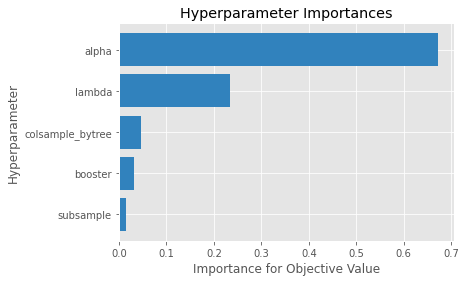

In [76]:
plot_param_importances(study);

## Finding the best parameter of the study

In [77]:
trial = study.best_trial
param=trial.params
param

{'booster': 'gbtree',
 'lambda': 0.40325644933377863,
 'alpha': 0.40722370399096586,
 'subsample': 0.19187946826573563,
 'colsample_bytree': 0.15302665725542017}

## Training model with the best parameters

In [78]:
xgb_obj = xgb.XGBClassifier(**param)
xgb_obj.fit(X_train, y_train)

[19:27:45] DEBUG: C:/Users/Administrator/workspace/xgboost-win64_release_1.6.0/src/gbm/gbtree.cc:155: Using tree method: 2
[19:27:45] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.6.0/src/tree/updater_prune.cc:101: tree pruning end, 32 extra nodes, 0 pruned nodes, max_depth=6
[19:27:45] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.6.0/src/tree/updater_prune.cc:101: tree pruning end, 18 extra nodes, 0 pruned nodes, max_depth=5
[19:27:45] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.6.0/src/tree/updater_prune.cc:101: tree pruning end, 24 extra nodes, 0 pruned nodes, max_depth=6
[19:27:45] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.6.0/src/tree/updater_prune.cc:101: tree pruning end, 2 extra nodes, 0 pruned nodes, max_depth=1
[19:27:45] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.6.0/src/tree/updater_prune.cc:101: tree pruning end, 24 extra nodes, 0 pruned nodes, max_depth=5
[19:27:45] INFO: C:/Use

[19:27:45] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.6.0/src/tree/updater_prune.cc:101: tree pruning end, 4 extra nodes, 0 pruned nodes, max_depth=2
[19:27:45] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.6.0/src/tree/updater_prune.cc:101: tree pruning end, 2 extra nodes, 0 pruned nodes, max_depth=1
[19:27:45] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.6.0/src/tree/updater_prune.cc:101: tree pruning end, 2 extra nodes, 0 pruned nodes, max_depth=1
[19:27:45] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.6.0/src/tree/updater_prune.cc:101: tree pruning end, 2 extra nodes, 0 pruned nodes, max_depth=1
[19:27:45] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.6.0/src/tree/updater_prune.cc:101: tree pruning end, 2 extra nodes, 0 pruned nodes, max_depth=1
[19:27:45] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.6.0/src/tree/updater_prune.cc:101: tree pruning end, 2 extra nodes, 0 pruned

XGBClassifier(alpha=0.40722370399096586, base_score=0.5, booster='gbtree',
              callbacks=None, colsample_bylevel=1, colsample_bynode=1,
              colsample_bytree=0.15302665725542017, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, gamma=0, gpu_id=-1,
              grow_policy='depthwise', importance_type=None,
              interaction_constraints='', lambda=0.40325644933377863,
              learning_rate=0.300000012, max_bin=256, max_cat_to_onehot=4,
              max_delta_step=0, max_depth=6, max_leaves=0, min_child_weight=1,
              missing=nan, monotone_constraints='()', n_estimators=100,
              n_jobs=0, num_parallel_tree=1, predictor='auto', random_state=0, ...)

## Evaluation metrics

In [79]:
y_pred=xgb_obj.predict(X_test)
print(confusion_matrix(y_test,y_pred))
print(accuracy_score(y_test,y_pred))
print(classification_report(y_test,y_pred))

[[229   0]
 [  0 229]]
1.0
              precision    recall  f1-score   support

         0.0       1.00      1.00      1.00       229
         1.0       1.00      1.00      1.00       229

    accuracy                           1.00       458
   macro avg       1.00      1.00      1.00       458
weighted avg       1.00      1.00      1.00       458



## Creating Function which can automatically select a best model from various models based on the recall and roc_auc_score . 

In [80]:

def objective(trial):
    """
                                Method Name: objective
                                Description: This function selects different ML classifiers and takes a variety of 
                                hyperparameter in different ranges and then depending on the scoring metrics maximizes 
                                this metrics and returns the hyperparameter that provided these better 
                                metrics alongwith the model which performed better
                                Outcome: We get the best hyperparameters of the model
                            

                                Written By: Saurabh Naik
                                Version: 1.0
                                Revisions: None
        """

    classifier_name = trial.suggest_categorical("classifier", ["LogReg", "RandomForest","SVC","NaiveBayes",
                                                               "decision-tree","xgb"])
    
    # Step 2. Setup values for the hyperparameters:
    if classifier_name == 'LogReg':
        C = trial.suggest_uniform('C', 0.01, 10)
        classifier_obj = linear_model.LogisticRegression(C=C)
    
    elif classifier_name == 'RandomForest':
        min_samples_split = trial.suggest_int('min_samples_split', 2, 20)
        min_samples_leaf = trial.suggest_int('min_samples_leaf', 2, 20)
        classifier_obj = sklearn.ensemble.RandomForestClassifier(min_samples_split=min_samples_split,
                                                                 min_samples_leaf=min_samples_leaf)
    
    elif classifier_name == 'SVC':
        kernel = trial.suggest_categorical('kernel', ['linear', 'poly', 'rbf', 'sigmoid'])
        classifier_obj = sklearn.svm.SVC(kernel=kernel)
        
    elif classifier_name == 'NaiveBayes':
        var_smoothing=trial.suggest_float("var_smoothing", 1e-4, 0.3, log=True)
        classifier_obj = sklearn.naive_bayes.GaussianNB(var_smoothing=var_smoothing)
    elif classifier_name == 'decision-tree':
        max_depth = trial.suggest_int('max_depth', 5, X_train.shape[1])
        classifier_obj = sklearn.tree.DecisionTreeClassifier(max_depth=max_depth)
    
    elif classifier_name == 'xgb':
        alpha =trial.suggest_float('alpha' , 1e-4 , 1)
        subsample =trial.suggest_float('subsample' , .1,.5)
        classifier_obj = xgb.XGBClassifier(alpha=alpha,subsample=subsample)

    # Step 3: Scoring method:
    score = model_selection.cross_val_score(classifier_obj, X_train, y_train, cv=3,scoring='recall')
    recall = score.mean()
    roc_auc_score = model_selection.cross_val_score(classifier_obj, X_train, y_train, scoring="roc_auc")
    roc_auc = roc_auc_score.mean()
    return recall,roc_auc

# Step 4: Running it
sampler = optuna.samplers.NSGAIISampler()
study = optuna.create_study(directions=["maximize", "maximize"], sampler=sampler)
study.optimize(objective, n_trials=10)

[I 2022-09-16 19:27:46,050] A new study created in memory with name: no-name-d45a89f3-2c15-471a-9f7c-bf52b9b5f3f8
[I 2022-09-16 19:27:46,307] Trial 0 finished with values: [1.0, 1.0] and parameters: {'classifier': 'NaiveBayes', 'var_smoothing': 0.26398727586698767}. 
[I 2022-09-16 19:27:46,660] Trial 1 finished with values: [1.0, 1.0] and parameters: {'classifier': 'SVC', 'kernel': 'poly'}. 


[19:27:46] DEBUG: C:/Users/Administrator/workspace/xgboost-win64_release_1.6.0/src/gbm/gbtree.cc:155: Using tree method: 2
[19:27:46] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.6.0/src/tree/updater_prune.cc:101: tree pruning end, 2 extra nodes, 0 pruned nodes, max_depth=1
[19:27:46] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.6.0/src/tree/updater_prune.cc:101: tree pruning end, 2 extra nodes, 0 pruned nodes, max_depth=1
[19:27:46] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.6.0/src/tree/updater_prune.cc:101: tree pruning end, 2 extra nodes, 0 pruned nodes, max_depth=1
[19:27:46] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.6.0/src/tree/updater_prune.cc:101: tree pruning end, 2 extra nodes, 0 pruned nodes, max_depth=1
[19:27:46] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.6.0/src/tree/updater_prune.cc:101: tree pruning end, 2 extra nodes, 0 pruned nodes, max_depth=1
[19:27:46] INFO: C:/Users/A

[19:27:46] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.6.0/src/tree/updater_prune.cc:101: tree pruning end, 0 extra nodes, 0 pruned nodes, max_depth=0
[19:27:46] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.6.0/src/tree/updater_prune.cc:101: tree pruning end, 0 extra nodes, 0 pruned nodes, max_depth=0
[19:27:46] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.6.0/src/tree/updater_prune.cc:101: tree pruning end, 0 extra nodes, 0 pruned nodes, max_depth=0
[19:27:46] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.6.0/src/tree/updater_prune.cc:101: tree pruning end, 0 extra nodes, 0 pruned nodes, max_depth=0
[19:27:46] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.6.0/src/tree/updater_prune.cc:101: tree pruning end, 0 extra nodes, 0 pruned nodes, max_depth=0
[19:27:46] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.6.0/src/tree/updater_prune.cc:101: tree pruning end, 0 extra nodes, 0 pruned

[19:27:47] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.6.0/src/tree/updater_prune.cc:101: tree pruning end, 0 extra nodes, 0 pruned nodes, max_depth=0
[19:27:47] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.6.0/src/tree/updater_prune.cc:101: tree pruning end, 0 extra nodes, 0 pruned nodes, max_depth=0
[19:27:47] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.6.0/src/tree/updater_prune.cc:101: tree pruning end, 0 extra nodes, 0 pruned nodes, max_depth=0
[19:27:47] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.6.0/src/tree/updater_prune.cc:101: tree pruning end, 0 extra nodes, 0 pruned nodes, max_depth=0
[19:27:47] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.6.0/src/tree/updater_prune.cc:101: tree pruning end, 0 extra nodes, 0 pruned nodes, max_depth=0
[19:27:47] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.6.0/src/tree/updater_prune.cc:101: tree pruning end, 0 extra nodes, 0 pruned

[19:27:47] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.6.0/src/tree/updater_prune.cc:101: tree pruning end, 0 extra nodes, 0 pruned nodes, max_depth=0
[19:27:47] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.6.0/src/tree/updater_prune.cc:101: tree pruning end, 0 extra nodes, 0 pruned nodes, max_depth=0
[19:27:47] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.6.0/src/tree/updater_prune.cc:101: tree pruning end, 0 extra nodes, 0 pruned nodes, max_depth=0
[19:27:47] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.6.0/src/tree/updater_prune.cc:101: tree pruning end, 0 extra nodes, 0 pruned nodes, max_depth=0
[19:27:47] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.6.0/src/tree/updater_prune.cc:101: tree pruning end, 0 extra nodes, 0 pruned nodes, max_depth=0
[19:27:47] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.6.0/src/tree/updater_prune.cc:101: tree pruning end, 0 extra nodes, 0 pruned

[19:27:47] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.6.0/src/tree/updater_prune.cc:101: tree pruning end, 0 extra nodes, 0 pruned nodes, max_depth=0
[19:27:47] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.6.0/src/tree/updater_prune.cc:101: tree pruning end, 0 extra nodes, 0 pruned nodes, max_depth=0
[19:27:47] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.6.0/src/tree/updater_prune.cc:101: tree pruning end, 0 extra nodes, 0 pruned nodes, max_depth=0
[19:27:47] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.6.0/src/tree/updater_prune.cc:101: tree pruning end, 0 extra nodes, 0 pruned nodes, max_depth=0
[19:27:47] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.6.0/src/tree/updater_prune.cc:101: tree pruning end, 0 extra nodes, 0 pruned nodes, max_depth=0
[19:27:47] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.6.0/src/tree/updater_prune.cc:101: tree pruning end, 0 extra nodes, 0 pruned

[19:27:48] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.6.0/src/tree/updater_prune.cc:101: tree pruning end, 0 extra nodes, 0 pruned nodes, max_depth=0
[19:27:48] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.6.0/src/tree/updater_prune.cc:101: tree pruning end, 0 extra nodes, 0 pruned nodes, max_depth=0
[19:27:48] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.6.0/src/tree/updater_prune.cc:101: tree pruning end, 0 extra nodes, 0 pruned nodes, max_depth=0
[19:27:48] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.6.0/src/tree/updater_prune.cc:101: tree pruning end, 0 extra nodes, 0 pruned nodes, max_depth=0
[19:27:48] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.6.0/src/tree/updater_prune.cc:101: tree pruning end, 0 extra nodes, 0 pruned nodes, max_depth=0
[19:27:48] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.6.0/src/tree/updater_prune.cc:101: tree pruning end, 0 extra nodes, 0 pruned

[19:27:48] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.6.0/src/tree/updater_prune.cc:101: tree pruning end, 0 extra nodes, 0 pruned nodes, max_depth=0
[19:27:48] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.6.0/src/tree/updater_prune.cc:101: tree pruning end, 0 extra nodes, 0 pruned nodes, max_depth=0
[19:27:48] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.6.0/src/tree/updater_prune.cc:101: tree pruning end, 0 extra nodes, 0 pruned nodes, max_depth=0
[19:27:48] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.6.0/src/tree/updater_prune.cc:101: tree pruning end, 0 extra nodes, 0 pruned nodes, max_depth=0
[19:27:48] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.6.0/src/tree/updater_prune.cc:101: tree pruning end, 0 extra nodes, 0 pruned nodes, max_depth=0
[19:27:48] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.6.0/src/tree/updater_prune.cc:101: tree pruning end, 0 extra nodes, 0 pruned

[19:27:48] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.6.0/src/tree/updater_prune.cc:101: tree pruning end, 0 extra nodes, 0 pruned nodes, max_depth=0
[19:27:48] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.6.0/src/tree/updater_prune.cc:101: tree pruning end, 0 extra nodes, 0 pruned nodes, max_depth=0
[19:27:48] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.6.0/src/tree/updater_prune.cc:101: tree pruning end, 0 extra nodes, 0 pruned nodes, max_depth=0
[19:27:48] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.6.0/src/tree/updater_prune.cc:101: tree pruning end, 0 extra nodes, 0 pruned nodes, max_depth=0
[19:27:48] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.6.0/src/tree/updater_prune.cc:101: tree pruning end, 0 extra nodes, 0 pruned nodes, max_depth=0
[19:27:48] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.6.0/src/tree/updater_prune.cc:101: tree pruning end, 0 extra nodes, 0 pruned

[19:27:49] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.6.0/src/tree/updater_prune.cc:101: tree pruning end, 0 extra nodes, 0 pruned nodes, max_depth=0
[19:27:49] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.6.0/src/tree/updater_prune.cc:101: tree pruning end, 0 extra nodes, 0 pruned nodes, max_depth=0
[19:27:49] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.6.0/src/tree/updater_prune.cc:101: tree pruning end, 0 extra nodes, 0 pruned nodes, max_depth=0
[19:27:49] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.6.0/src/tree/updater_prune.cc:101: tree pruning end, 0 extra nodes, 0 pruned nodes, max_depth=0
[19:27:49] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.6.0/src/tree/updater_prune.cc:101: tree pruning end, 0 extra nodes, 0 pruned nodes, max_depth=0
[19:27:49] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.6.0/src/tree/updater_prune.cc:101: tree pruning end, 0 extra nodes, 0 pruned

[19:27:49] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.6.0/src/tree/updater_prune.cc:101: tree pruning end, 0 extra nodes, 0 pruned nodes, max_depth=0
[19:27:49] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.6.0/src/tree/updater_prune.cc:101: tree pruning end, 0 extra nodes, 0 pruned nodes, max_depth=0
[19:27:49] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.6.0/src/tree/updater_prune.cc:101: tree pruning end, 0 extra nodes, 0 pruned nodes, max_depth=0
[19:27:49] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.6.0/src/tree/updater_prune.cc:101: tree pruning end, 0 extra nodes, 0 pruned nodes, max_depth=0
[19:27:49] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.6.0/src/tree/updater_prune.cc:101: tree pruning end, 0 extra nodes, 0 pruned nodes, max_depth=0
[19:27:49] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.6.0/src/tree/updater_prune.cc:101: tree pruning end, 0 extra nodes, 0 pruned

[I 2022-09-16 19:27:49,936] Trial 2 finished with values: [1.0, 1.0] and parameters: {'classifier': 'xgb', 'alpha': 0.12569812495021454, 'subsample': 0.21230451192495578}. 



[19:27:49] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.6.0/src/tree/updater_prune.cc:101: tree pruning end, 0 extra nodes, 0 pruned nodes, max_depth=0
[19:27:49] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.6.0/src/tree/updater_prune.cc:101: tree pruning end, 0 extra nodes, 0 pruned nodes, max_depth=0
[19:27:49] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.6.0/src/tree/updater_prune.cc:101: tree pruning end, 0 extra nodes, 0 pruned nodes, max_depth=0
[19:27:49] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.6.0/src/tree/updater_prune.cc:101: tree pruning end, 0 extra nodes, 0 pruned nodes, max_depth=0
[19:27:49] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.6.0/src/tree/updater_prune.cc:101: tree pruning end, 0 extra nodes, 0 pruned nodes, max_depth=0
[19:27:49] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.6.0/src/tree/updater_prune.cc:101: tree pruning end, 0 extra nodes, 0 prune

[I 2022-09-16 19:27:50,219] Trial 3 finished with values: [1.0, 1.0] and parameters: {'classifier': 'decision-tree', 'max_depth': 9}. 
[I 2022-09-16 19:27:50,328] Trial 4 finished with values: [1.0, 1.0] and parameters: {'classifier': 'NaiveBayes', 'var_smoothing': 0.10366087799132738}. 
[I 2022-09-16 19:27:50,460] Trial 5 finished with values: [1.0, 1.0] and parameters: {'classifier': 'decision-tree', 'max_depth': 12}. 
[I 2022-09-16 19:27:50,689] Trial 6 finished with values: [1.0, 1.0] and parameters: {'classifier': 'LogReg', 'C': 9.605675829548648}. 
[I 2022-09-16 19:27:50,956] Trial 7 finished with values: [0.9978768577494691, 0.9999552071668532] and parameters: {'classifier': 'SVC', 'kernel': 'sigmoid'}. 
[I 2022-09-16 19:27:51,098] Trial 8 finished with values: [1.0, 1.0] and parameters: {'classifier': 'SVC', 'kernel': 'linear'}. 
[I 2022-09-16 19:27:54,488] Trial 9 finished with values: [1.0, 1.0] and parameters: {'classifier': 'RandomForest', 'min_samples_split': 7, 'min_sampl

## Finding the best Recall and auc roc score and also the hyperparameter among all study

In [81]:
trial = study.best_trials
trial[0]
print('Recall and Auc roc score: {}'.format(trial[0].values))
print("Best hyperparameters: {}".format(trial[0].params))

Recall and Auc roc score: [1.0, 1.0]
Best hyperparameters: {'classifier': 'NaiveBayes', 'var_smoothing': 0.26398727586698767}


In [82]:
trial = study.best_trials
param=trial[0].params
param

{'classifier': 'NaiveBayes', 'var_smoothing': 0.26398727586698767}

## Training model with best hyperparameter

In [83]:
# dt=sklearn.tree.DecisionTreeClassifier(max_depth=param['max_depth'])
# dt.fit(X_train,y_train)
nb=sklearn.naive_bayes.GaussianNB(var_smoothing=param['var_smoothing'])
nb.fit(X_train,y_train)

GaussianNB(var_smoothing=0.26398727586698767)

## Evaluation metrics

In [86]:
y_pred=nb.predict(X_test)
print(confusion_matrix(y_test,y_pred))
print(accuracy_score(y_test,y_pred))
print(roc_auc_score(y_test, y_pred))
print(classification_report(y_test,y_pred))

[[229   0]
 [  0 229]]
1.0
1.0
              precision    recall  f1-score   support

         0.0       1.00      1.00      1.00       229
         1.0       1.00      1.00      1.00       229

    accuracy                           1.00       458
   macro avg       1.00      1.00      1.00       458
weighted avg       1.00      1.00      1.00       458



## Saving the model for prediction

In [87]:
joblib.dump(nb, 'model.pkl')

['model.pkl']

## 1. Explain your intuition behind the features used for modeling.
## Solution: After performing feature Selection(Removing features having 0 varience and features which are correlated with each other more than 80%) we were left with 21 independent features

## 2. Are you creating new derived features? If yes explain the intuition behind them.
## Solution: No, I have not created derived features

## 3. Are there missing values? If yes how you plan to handle it.
## Solution: Yes,There were missing values in the given dataset. Upon some analysis it was found that the missing values were from categorical features.So for handling missing values in categorical features we just added a new Category with name "Missing"

## 4. How categorical features are handled for modeling.
## Solution: It is important that before modelling we need to convert categorical features into numerical features. So for that we first need to divide categorical features into ordinal and nominal features.In ordinal features rank matters(for eg. if we are converting salary category column into numerical then we need to assign high values to the senior employees and low value to the junior employees).For nominal features order does'nt matter. For ordinal features technique call target guided encoding was used and for nominal features technique called mean encoding was used

## 5. Describe the features correlation using correlation matrix. Tell us about few correlated feature & share your understanding on why they are correlated.

## Solution:Correlation matrix is drawn in this notebook while performing feature Selection you  can just refer that on the top.

## While keeping Threshold = 80% only 2 features were found correlating to each other.They are (has_been_employed_for_atleast) and (has_been_employed_for_atmost).

## They are correlated because they are related to experience

## 6. Do you plan to drop the correlated feature? If yes then how.
## Solution: Yes, I have dropped the correlated features by creating a function that takes input as a dataframe and a threshold value and then creating a correlation matrix and comparing each row with each column correlation value with the threshold value. If this values is greater than the threshold value then it will be inserted into the set variable and after, all rows and columns are traversed the set having correlated features will be returned

## 7. Which ML algorithm you plan to use for modeling.
## Solution: I tried to use all the classification algorithms known to me like Logistic regression,Descision Tree Classifier, Random forest Classifier, XGBoost Classifier,Support Vector Classifier,Naive Bayes.

## 8. Train two (at least) ML models to predict the credit risk & provide the confusion matrix for each model.
## Solution: In the above solution I have provided all the evalution metrics for all the algorithms used,Kindly check the same.

## 9.How you will select the hyperparameters for models trained in above step.
## Solution: In this solution I used optuna for hyperparameter tuning, so this libary provides the graphical visualization to show which hyperparameter contributes how much.The same is demonstrated above.Depending upon this contribution we can select the same

## 10. Which metric(s) you will choose to select between the set of models.
## Solution: As asked in the problem statement that it is ok to state an applicant to be a high credit risk when they aren’t but not true vice versa.So I think we should focus more on reducing False negative and thus to do that we need to focus on recall to achieve it.

## 11. Explain how you will export the trained models & deploy it for prediction in production.
## Solution: We Can use joblib.dump() as well as pickle.dump() to save our model and then load it while doing prediction. We can deploy it into production after dockerizing it and then establishing a CI-CD pipeline to the production environment